# Polymer Representation Analysis Resources

https://zoehlerbz.medium.com/molecule-clustering-using-the-butina-algorithm-application-with-python-and-rdkit-ffb5b5721447

https://github.com/zoehlerbz/rdkit_basico

https://www.osti.gov/pages/servlets/purl/2328569

https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file

https://drzinph.com/maccs-fingerprints-in-python-part-2/

https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Murtagh.html

https://github.com/argonne-lcf/molan/tree/master/code/melting_predict_Spark_RF



In [1]:
%pip install rdkit umap-learn tqdm scikit-learn pandas numpy matplotlib plotly transformers accelerate torch mordred

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
# Force transformers to use PyTorch only (avoid TensorFlow import issues)
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['USE_TF'] = '0'

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    accuracy_score, f1_score, classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
from transformers import AutoTokenizer, AutoModel

print("All imports successful!")
# Mordred descriptors
from mordred import Calculator, descriptors
import mordred


All imports successful!


## 1. Load and Clean Dataset
### 1.1 Load Data

In [3]:
import pandas as pd

# Load from local file (fallback from GitHub URL)
LOCAL_PATH = "/Users/Omer/Desktop/Research/data/PI1070.csv"
RAW_URL = "https://raw.githubusercontent.com/Syedomershah99/AI-for-Polymer-Representation/main/PI1070.csv"

import os
if os.path.exists(LOCAL_PATH):
    print(f"Loading from local file: {LOCAL_PATH}")
    df_raw = pd.read_csv(LOCAL_PATH)
else:
    print(f"Loading from URL: {RAW_URL}")
    df_raw = pd.read_csv(RAW_URL)

print(f"Loaded dataset: {df_raw.shape}")
print(f"Columns: {df_raw.columns[:15].tolist()}...")
df_raw.head(3)

Loading from local file: /Users/Omer/Desktop/Research/data/PI1070.csv
Loaded dataset: (1077, 157)
Columns: ['monomer_ID', 'smiles', 'mol_weight_monomer', 'atomic_weight_mean', 'vdw_volume_monomer', 'qm_total_energy_monomer', 'qm_homo_monomer', 'qm_lumo_monomer', 'qm_dipole_monomer', 'qm_dipole_x_monomer', 'qm_dipole_y_monomer', 'qm_dipole_z_monomer', 'qm_polarizability_monomer', 'qm_polarizability_xx_monomer', 'qm_polarizability_yy_monomer']...


,monomer_ID,smiles,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,...,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class
0,PI1,*CC*,28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,...,0.0,0.0,0.0,5.0,0.000014,-0.000028,0.000029,0.000024,5.0,1
1,PI2,*C(C*)C,42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.003980,...,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1
2,PI3,*C(C*)CC,56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,...,0.0,0.0,0.0,5.0,0.000059,-0.000043,0.000288,0.000133,5.0,1


### 1.2 Canonicalize SMILES and Clean Dataset

In [4]:
def canonicalize_smiles(smiles):
    """
    Canonicalize SMILES string using RDKit.
    Returns canonical SMILES or None if invalid.
    """
    try:
        smiles = str(smiles).strip()
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

def clean_dataset(df):
    """
    Clean the dataset:
    1. Canonicalize SMILES
    2. Remove invalid entries
    3. Deduplicate based on canonical SMILES
    """
    df = df.copy()
    
    # Step 1: Canonicalize SMILES
    print("Canonicalizing SMILES...")
    tqdm.pandas(desc="Canonicalizing")
    df['smiles_canonical'] = df['smiles'].progress_apply(canonicalize_smiles)
    
    # Step 2: Remove invalid SMILES
    n_before = len(df)
    df = df[df['smiles_canonical'].notna()].reset_index(drop=True)
    n_invalid = n_before - len(df)
    print(f"Removed {n_invalid} invalid SMILES entries")
    
    # Step 3: Deduplicate based on canonical SMILES
    n_before = len(df)
    df = df.drop_duplicates(subset='smiles_canonical', keep='first').reset_index(drop=True)
    n_duplicates = n_before - len(df)
    print(f"Removed {n_duplicates} duplicate SMILES entries")
    
    # Create mol objects
    df['mol'] = df['smiles_canonical'].apply(lambda s: Chem.MolFromSmiles(s))
    
    print(f"Final dataset size: {len(df)}")
    return df

df = clean_dataset(df_raw)
print(f"\nDataset summary:")
print(f"  - Total polymers: {len(df)}")
print(f"  - Has polymer_class: {'polymer_class' in df.columns}")
if 'polymer_class' in df.columns:
    print(f"  - Unique classes: {df['polymer_class'].nunique()}")
    print(f"  - Class distribution:\n{df['polymer_class'].value_counts()}")

Canonicalizing SMILES...


Canonicalizing:   0%|          | 0/1077 [00:00<?, ?it/s]

Removed 0 invalid SMILES entries
Removed 0 duplicate SMILES entries
Final dataset size: 1077

Dataset summary:
  - Total polymers: 1077
  - Has polymer_class: True
  - Unique classes: 20
  - Class distribution:
polymer_class
13    261
3     162
2     161
4     118
1      83
7      67
9      67
10     50
15     40
16     11
11     11
8      11
6       9
5       8
21      6
12      5
20      4
14      1
18      1
19      1
Name: count, dtype: int64


## 2. Compute Polymer Representations

We compute four types of representations:
1. **Morgan Fingerprints** (ECFP) - circular fingerprints capturing local atom environments
2. **MACCS Keys** - 166 predefined structural keys (standard substructure patterns)
3. **RDKit Descriptors + MACCS Motifs** - physicochemical descriptors with substructure information
4. **Transformer Embeddings** - pretrained polyBERT embeddings

### 2.1 Morgan Fingerprints (ECFP)

In [5]:
def compute_morgan_fingerprints(mols, radius=2, n_bits=2048):
    """
    Compute Morgan fingerprints (ECFP) for a list of molecules.
    Returns both RDKit bitvectors and numpy arrays.
    """
    fps_rdkit = []  # For Tanimoto calculations
    fps_array = []  # For ML models
    
    for mol in tqdm(mols, desc="Computing Morgan FPs"):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        fps_rdkit.append(fp)
        
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_morgan_rdkit, X_morgan = compute_morgan_fingerprints(df['mol'].tolist())
print(f"Morgan fingerprints shape: {X_morgan.shape}")
print(f"Sparsity: {100 * (X_morgan == 0).sum() / X_morgan.size:.1f}%")

Computing Morgan FPs:   0%|          | 0/1077 [00:00<?, ?it/s]

Morgan fingerprints shape: (1077, 2048)
Sparsity: 98.5%


### 2.2 MACCS Keys (166 Standard Substructure Patterns)

In [6]:
def compute_maccs_keys(mols):
    """
    Compute MACCS keys (166-bit structural keys) for molecules.
    MACCS keys are standard substructure patterns widely used in cheminformatics.
    """
    fps_rdkit = []
    fps_array = []
    
    for mol in tqdm(mols, desc="Computing MACCS keys"):
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps_rdkit.append(fp)
        
        arr = np.zeros((167,), dtype=np.int8)  # MACCS has 167 bits (0-166)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_maccs_rdkit, X_maccs = compute_maccs_keys(df['mol'].tolist())
print(f"MACCS keys shape: {X_maccs.shape}")
print(f"Active bits per molecule (mean): {X_maccs.sum(axis=1).mean():.1f}")

Computing MACCS keys:   0%|          | 0/1077 [00:00<?, ?it/s]

MACCS keys shape: (1077, 167)
Active bits per molecule (mean): 27.2


### 2.3 RDKit Descriptors + MACCS Motifs

In [7]:
def compute_rdkit_descriptors(mols):
    """
    Compute all RDKit molecular descriptors.
    Handles NaN/Inf values by imputing with column medians.
    """
    # Use only first 185 descriptors to match training data (avoid version mismatch)
    descriptor_names = [d[0] for d in Descriptors._descList[:161]]
    descriptor_fns = [d[1] for d in Descriptors._descList[:161]]
    
    results = []
    for mol in tqdm(mols, desc="Computing RDKit descriptors"):
        vals = []
        for fn in descriptor_fns:
            try:
                v = fn(mol)
                if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                    v = np.nan
            except Exception:
                v = np.nan
            vals.append(v)
        results.append(vals)
    
    X = np.array(results, dtype=np.float32)
    
    # Remove columns that are all NaN
    valid_mask = ~np.all(np.isnan(X), axis=0)
    X = X[:, valid_mask]
    kept_names = [n for n, keep in zip(descriptor_names, valid_mask) if keep]
    
    # Impute remaining NaNs with column medians
    col_median = np.nanmedian(X, axis=0)
    nan_idx = np.where(np.isnan(X))
    X[nan_idx] = np.take(col_median, nan_idx[1])
    
    return X, kept_names

X_rdkit_desc, rdkit_desc_names = compute_rdkit_descriptors(df['mol'].tolist())
print(f"RDKit descriptors shape: {X_rdkit_desc.shape}")

# Combine RDKit descriptors with MACCS keys as motif representation
X_desc_maccs = np.hstack([X_rdkit_desc, X_maccs.astype(np.float32)])
print(f"RDKit + MACCS combined shape: {X_desc_maccs.shape}")

Computing RDKit descriptors:   0%|          | 0/1077 [00:00<?, ?it/s]

RDKit descriptors shape: (1077, 153)
RDKit + MACCS combined shape: (1077, 320)


### 2.4 Mordred Descriptors

Mordred is a molecular descriptor calculator that computes ~1800 descriptors.
It provides a comprehensive set of 2D and 3D molecular descriptors for QSAR/QSPR modeling.

In [8]:
def compute_mordred_descriptors(mols):
    """
    Compute Mordred molecular descriptors (~1800 2D descriptors).
    Handles NaN/Inf/Error values by imputing with column medians.
    
    Parameters:
    -----------
    mols : list
        List of RDKit molecule objects
    
    Returns:
    --------
    X : ndarray
        Mordred descriptor matrix (n_samples, n_descriptors)
    descriptor_names : list
        Names of kept descriptors
    """
    # Create calculator (2D descriptors only, ignore 3D)
    calc = Calculator(descriptors, ignore_3D=True)
    
    results = []
    for mol in tqdm(mols, desc="Computing Mordred descriptors"):
        try:
            desc = calc(mol)
            # Convert to float, handle Missing/Error values as NaN
            vals = []
            for v in desc.values():
                if isinstance(v, (mordred.error.Missing, mordred.error.Error)):
                    vals.append(np.nan)
                else:
                    try:
                        vals.append(float(v))
                    except (ValueError, TypeError):
                        vals.append(np.nan)
        except Exception:
            vals = [np.nan] * len(calc.descriptors)
        results.append(vals)
    
    X = np.array(results, dtype=np.float32)
    descriptor_names = [str(d) for d in calc.descriptors]
    
    print(f"Initial Mordred shape: {X.shape}")
    
    # Remove columns that are all NaN
    valid_mask = ~np.all(np.isnan(X), axis=0)
    X = X[:, valid_mask]
    kept_names = [n for n, keep in zip(descriptor_names, valid_mask) if keep]
    print(f"After removing all-NaN columns: {X.shape}")
    
    # Remove zero-variance columns
    variance = np.nanvar(X, axis=0)
    var_mask = variance > 1e-10
    X = X[:, var_mask]
    kept_names = [n for n, keep in zip(kept_names, var_mask) if keep]
    print(f"After removing zero-variance columns: {X.shape}")
    
    # Replace Inf with NaN
    X = np.where(np.isinf(X), np.nan, X)
    
    # Impute remaining NaNs with column medians
    col_median = np.nanmedian(X, axis=0)
    nan_idx = np.where(np.isnan(X))
    if len(nan_idx[0]) > 0:
        X[nan_idx] = np.take(col_median, nan_idx[1])
        print(f"Imputed {len(nan_idx[0])} NaN values with column medians")
    
    return X, kept_names

# Compute Mordred descriptors
X_mordred, mordred_desc_names = compute_mordred_descriptors(df['mol'].tolist())
print(f"\nFinal Mordred descriptors shape: {X_mordred.shape}")
print(f"Number of descriptors: {len(mordred_desc_names)}")

Computing Mordred descriptors:   0%|          | 0/1077 [00:00<?, ?it/s]

Initial Mordred shape: (1077, 1613)
After removing all-NaN columns: (1077, 879)
After removing zero-variance columns: (1077, 701)
Imputed 82464 NaN values with column medians

Final Mordred descriptors shape: (1077, 701)
Number of descriptors: 701


### 2.5 Transformer Embeddings (polyBERT)

In [9]:
import os
# Force transformers to use PyTorch only (avoid TensorFlow import issues)
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['USE_TF'] = '0'

def compute_transformer_embeddings(smiles_list, model_name="kuelumbus/polyBERT", 
                                    batch_size=64, max_len=256, pooling="cls"):
    """
    Compute transformer embeddings using a pretrained SMILES encoder.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(smiles_list), batch_size), desc="Computing embeddings"):
            batch = smiles_list[i:i+batch_size]
            
            tokens = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)
            
            output = model(**tokens)
            hidden = output.last_hidden_state
            
            if pooling == "cls":
                emb = hidden[:, 0, :]
            else:  # mean pooling
                mask = tokens["attention_mask"].unsqueeze(-1)
                emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            
            embeddings.append(emb.cpu().numpy())
    
    return np.vstack(embeddings)

X_transformer = compute_transformer_embeddings(df['smiles_canonical'].tolist())
print(f"Transformer embeddings shape: {X_transformer.shape}")

Using device: cpu


Computing embeddings:   0%|          | 0/17 [00:00<?, ?it/s]

Transformer embeddings shape: (1077, 600)


### 2.6 Standardize Representations

In [10]:
# Create output directories if they don't exist
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('representations', exist_ok=True)

# Standardize continuous representations (not binary fingerprints)
scaler_rdkit = StandardScaler()
X_rdkit_desc_scaled = scaler_rdkit.fit_transform(X_rdkit_desc)

scaler_mordred = StandardScaler()
X_mordred_scaled = scaler_mordred.fit_transform(X_mordred)

scaler_desc_maccs = StandardScaler()
X_desc_maccs_scaled = scaler_desc_maccs.fit_transform(X_desc_maccs)

scaler_transformer = StandardScaler()
X_transformer_scaled = scaler_transformer.fit_transform(X_transformer)

# Summary of all representations
print("\n=== Representation Summary ===")
print(f"Morgan FP (binary):        {X_morgan.shape}")
print(f"MACCS Keys (binary):       {X_maccs.shape}")
print(f"RDKit Desc (scaled):       {X_rdkit_desc_scaled.shape}")
print(f"Mordred Desc (scaled):     {X_mordred_scaled.shape}")
print(f"RDKit+MACCS (scaled):      {X_desc_maccs_scaled.shape}")
print(f"Transformer (scaled):      {X_transformer_scaled.shape}")


=== Representation Summary ===
Morgan FP (binary):        (1077, 2048)
MACCS Keys (binary):       (1077, 167)
RDKit Desc (scaled):       (1077, 153)
Mordred Desc (scaled):     (1077, 701)
RDKit+MACCS (scaled):      (1077, 320)
Transformer (scaled):      (1077, 600)


## 3. Save Input Representations to Disk

Save all computed representations in a reusable format with:
- Compressed numpy arrays (.npz)
- Mapping table (polymer_id, SMILES, class, row index)
- Tanimoto distance matrix for clustering

In [11]:
# Save each representation
print("Saving representations to disk...\n")

# 1. Morgan fingerprints
np.savez_compressed('representations/morgan_fp.npz',
                   data=X_morgan, shape=X_morgan.shape)
print(f"✓ Morgan fingerprints: {X_morgan.shape}")

# 2. MACCS keys
np.savez_compressed('representations/maccs_keys.npz',
                   data=X_maccs, shape=X_maccs.shape)
print(f"✓ MACCS keys: {X_maccs.shape}")

# 3. RDKit descriptors
np.savez_compressed('representations/rdkit_desc.npz',
                   data=X_rdkit_desc_scaled, shape=X_rdkit_desc_scaled.shape)
print(f"✓ RDKit descriptors: {X_rdkit_desc_scaled.shape}")

# 4. Mordred descriptors
np.savez_compressed('representations/mordred_desc.npz',
                   data=X_mordred_scaled, shape=X_mordred_scaled.shape)
print(f"✓ Mordred descriptors: {X_mordred_scaled.shape}")

# 5. RDKit + MACCS
np.savez_compressed('representations/rdkit_maccs.npz',
                   data=X_desc_maccs_scaled, shape=X_desc_maccs_scaled.shape)
print(f"✓ RDKit+MACCS: {X_desc_maccs_scaled.shape}")

# 6. Transformer embeddings
np.savez_compressed('representations/transformer_emb.npz',
                   data=X_transformer_scaled, shape=X_transformer_scaled.shape)
print(f"✓ Transformer embeddings: {X_transformer_scaled.shape}")

Saving representations to disk...

✓ Morgan fingerprints: (1077, 2048)
✓ MACCS keys: (1077, 167)
✓ RDKit descriptors: (1077, 153)
✓ Mordred descriptors: (1077, 701)
✓ RDKit+MACCS: (1077, 320)
✓ Transformer embeddings: (1077, 600)


In [12]:
# Compute and save Tanimoto distance matrix
def compute_tanimoto_distance_matrix(fps):
    """Compute pairwise Tanimoto distance matrix."""
    n = len(fps)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        if i % 100 == 0:
            print(f"  Computing row {i}/{n}")
        # Compute similarities for row i
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        # Convert to distances
        dist_matrix[i, :] = 1.0 - np.array(sims)

    return dist_matrix

print("\nComputing Tanimoto distance matrix...")
tanimoto_dist = compute_tanimoto_distance_matrix(fps_morgan_rdkit)
np.savez_compressed('representations/tanimoto_distance_morgan.npz',
                   data=tanimoto_dist, shape=tanimoto_dist.shape)
print(f"✓ Tanimoto distance matrix: {tanimoto_dist.shape}")


Computing Tanimoto distance matrix...
  Computing row 0/1077
  Computing row 100/1077
  Computing row 200/1077
  Computing row 300/1077
  Computing row 400/1077
  Computing row 500/1077
  Computing row 600/1077
  Computing row 700/1077
  Computing row 800/1077
  Computing row 900/1077
  Computing row 1000/1077
✓ Tanimoto distance matrix: (1077, 1077)


In [13]:
# Save mapping table
mapping_df = df[['smiles_canonical', 'polymer_class']].copy()
mapping_df['polymer_id'] = range(len(mapping_df))
mapping_df['row_index'] = range(len(mapping_df))
mapping_df = mapping_df[['polymer_id', 'smiles_canonical', 'polymer_class', 'row_index']]
mapping_df.to_csv('representations/mapping_table.csv', index=False)

print(f"\n✓ Mapping table saved: {len(mapping_df)} polymers")
print("\n" + "="*70)
print("All representations saved successfully!")
print("="*70)


✓ Mapping table saved: 1077 polymers

All representations saved successfully!


## 4. Murtagh Hierarchical Clustering (K = 2 to 25)

Implement hierarchical clustering using Murtagh-style linkage:
- **Input**: Tanimoto distance matrix from Morgan fingerprints
- **Method**: Average linkage (UPGMA - Unweighted Pair Group Method with Arithmetic mean)
- **K values**: 2 to 25
- **Output**: Cluster assignments for each K

**Why Murtagh?**
- More robust than Butina clustering
- Deterministic results (vs Butina's cutoff-dependent behavior)
- Allows testing multiple K values systematically

In [14]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

def murtagh_hierarchical_clustering(distance_matrix, k_values, method='average'):
    """
    Perform Murtagh hierarchical clustering for multiple K values.

    Parameters:
    -----------
    distance_matrix : ndarray
        Square distance matrix
    k_values : list
        List of K values to test
    method : str
        Linkage method ('average' for UPGMA, 'complete', 'single', 'ward')

    Returns:
    --------
    dict with linkage matrix and cluster assignments for each K
    """
    # Convert distance matrix to condensed form for scipy
    condensed_dist = squareform(distance_matrix, checks=False)

    # Perform hierarchical clustering
    print(f"Performing {method} linkage hierarchical clustering...")
    linkage_matrix = linkage(condensed_dist, method=method)

    # Get cluster assignments for each K
    results = {
        'linkage_matrix': linkage_matrix,
        'clusters': {},
        'metrics': []
    }

    for k in k_values:
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        results['clusters'][k] = clusters

    return results

# Define K values to test (2 to 25)
k_values = list(range(2, 26))

print("="*70)
print("MURTAGH HIERARCHICAL CLUSTERING ON TANIMOTO DISTANCE")
print("="*70)

# Perform clustering
murtagh_results = murtagh_hierarchical_clustering(
    tanimoto_dist,
    k_values,
    method='average'  # Murtagh-style UPGMA
)

print(f"✓ Clustering completed for K = {k_values[0]} to {k_values[-1]}")
print(f"✓ Total cluster assignments: {len(k_values)}")

MURTAGH HIERARCHICAL CLUSTERING ON TANIMOTO DISTANCE
Performing average linkage hierarchical clustering...
✓ Clustering completed for K = 2 to 25
✓ Total cluster assignments: 24


## 5. Evaluate Clustering Quality (ARI, NMI, Silhouette)

For each K value (2-25), compute:

1. **ARI (Adjusted Rand Index)**:
   - Measures agreement between clustering and true labels
   - Range: -1 to 1 (higher is better)
   - Adjusted for chance (0 = random labeling)

2. **NMI (Normalized Mutual Information)**:
   - Measures shared information between clustering and true labels
   - Range: 0 to 1 (higher is better)
   - Less sensitive to cluster size imbalance than ARI

3. **Silhouette Score**:
   - Internal cluster quality metric (no true labels needed)
   - Range: -1 to 1 (higher is better)
   - Measures how similar an object is to its cluster vs other clusters

These metrics help identify the optimal number of clusters.

In [15]:
# Evaluate clustering for each K
print("\nEvaluating clustering quality for each K...\n")

for k in k_values:
    clusters = murtagh_results['clusters'][k]

    # Compute silhouette score
    sil_score = silhouette_score(tanimoto_dist, clusters, metric='precomputed')

    # Compute ARI and NMI with true polymer classes
    if 'polymer_class' in df.columns and df['polymer_class'].notna().any():
        true_labels = df['polymer_class'].values
        ari = adjusted_rand_score(true_labels, clusters)
        nmi = normalized_mutual_info_score(true_labels, clusters)
    else:
        ari = None
        nmi = None

    # Store results
    murtagh_results['metrics'].append({
        'K': k,
        'n_clusters': len(np.unique(clusters)),
        'silhouette': sil_score,
        'ARI': ari,
        'NMI': nmi
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(murtagh_results['metrics'])

print("Clustering Quality Metrics:")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)

# Save metrics
metrics_df.to_csv('plots/clustering_metrics_k2_to_k25.csv', index=False)
print("\n✓ Metrics saved: plots/clustering_metrics_k2_to_k25.csv")


Evaluating clustering quality for each K...

Clustering Quality Metrics:
 K  n_clusters  silhouette      ARI      NMI
 2           2    0.086658 0.002866 0.022978
 3           3    0.077793 0.007308 0.043432
 4           4    0.068103 0.007319 0.047559
 5           5    0.113133 0.230220 0.357121
 6           6    0.107494 0.233279 0.370222
 7           7    0.103388 0.233250 0.371412
 8           8    0.107251 0.253512 0.389046
 9           9    0.097455 0.260598 0.406339
10          10    0.096046 0.260646 0.408372
11          11    0.091009 0.260656 0.409655
12          12    0.090341 0.260693 0.411542
13          13    0.087822 0.268925 0.427192
14          14    0.102219 0.371774 0.466781
15          15    0.102099 0.386794 0.477529
16          16    0.101074 0.386836 0.478917
17          17    0.121199 0.482273 0.551489
18          18    0.120003 0.482280 0.552126
19          19    0.131101 0.509940 0.583955
20          20    0.127022 0.510878 0.584483
21          21    0.127599

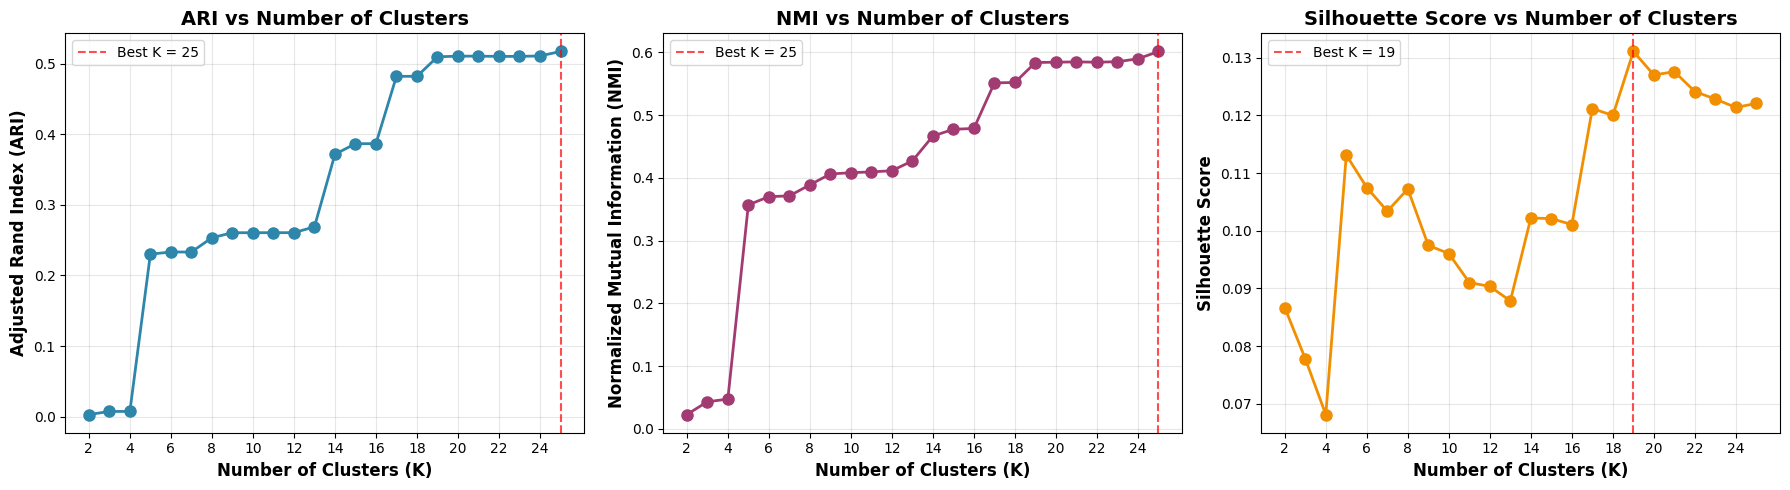


✓ Plot saved: plots/01_clustering_metrics_vs_k.png

Best K values:
  - ARI: K = 25 (ARI = 0.5175)
  - NMI: K = 25 (NMI = 0.6015)
  - Silhouette: K = 19 (Score = 0.1311)


In [16]:
# Plot ARI, NMI, and Silhouette vs K
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: ARI vs K
axes[0].plot(metrics_df['K'], metrics_df['ARI'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
best_k_ari = metrics_df.loc[metrics_df['ARI'].idxmax(), 'K']
axes[0].axvline(best_k_ari, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_ari)}')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Adjusted Rand Index (ARI)', fontsize=12, fontweight='bold')
axes[0].set_title('ARI vs Number of Clusters', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(range(2, 26, 2))

# Plot 2: NMI vs K
axes[1].plot(metrics_df['K'], metrics_df['NMI'], 'o-', linewidth=2, markersize=8, color='#A23B72')
best_k_nmi = metrics_df.loc[metrics_df['NMI'].idxmax(), 'K']
axes[1].axvline(best_k_nmi, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_nmi)}')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Normalized Mutual Information (NMI)', fontsize=12, fontweight='bold')
axes[1].set_title('NMI vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(range(2, 26, 2))

# Plot 3: Silhouette Score vs K
axes[2].plot(metrics_df['K'], metrics_df['silhouette'], 'o-', linewidth=2, markersize=8, color='#F18F01')
best_k_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'K']
axes[2].axvline(best_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_sil)}')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[2].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xticks(range(2, 26, 2))

plt.tight_layout()
plt.savefig('plots/01_clustering_metrics_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: plots/01_clustering_metrics_vs_k.png")
print(f"\nBest K values:")
print(f"  - ARI: K = {int(best_k_ari)} (ARI = {metrics_df.loc[metrics_df['ARI'].idxmax(), 'ARI']:.4f})")
print(f"  - NMI: K = {int(best_k_nmi)} (NMI = {metrics_df.loc[metrics_df['NMI'].idxmax(), 'NMI']:.4f})")
print(f"  - Silhouette: K = {int(best_k_sil)} (Score = {metrics_df.loc[metrics_df['silhouette'].idxmax(), 'silhouette']:.4f})")

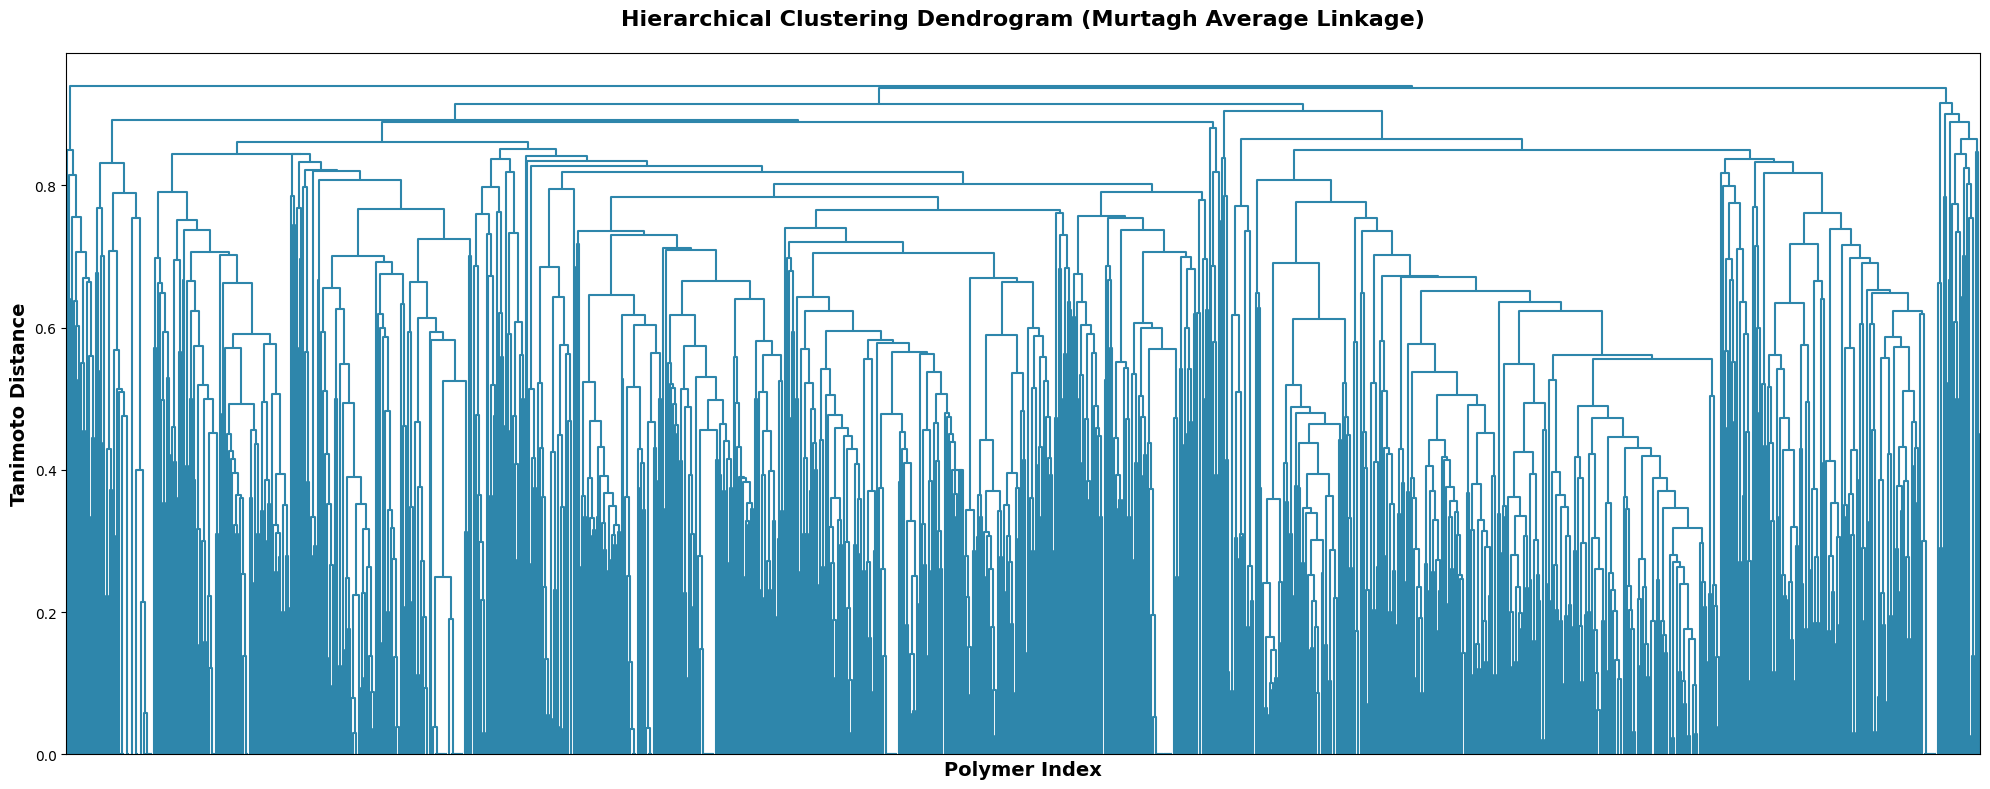

✓ Dendrogram saved: plots/02_dendrogram_murtagh.png


In [17]:
# Plot dendrogram
plt.figure(figsize=(20, 8))
dendrogram(
    murtagh_results['linkage_matrix'],
    no_labels=True,
    color_threshold=0,
    above_threshold_color='#2E86AB'
)
plt.title('Hierarchical Clustering Dendrogram (Murtagh Average Linkage)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Polymer Index', fontsize=14, fontweight='bold')
plt.ylabel('Tanimoto Distance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/02_dendrogram_murtagh.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrogram saved: plots/02_dendrogram_murtagh.png")

## 6. Supervised Learning: 5 Repeats of 70:30 Train-Test Split

**Change from original**: Instead of 5-fold cross-validation, we now use 5 independent 70:30 stratified splits.

For each representation, we:
1. Split data 70% train / 30% test (stratified by polymer class)
2. Train Logistic Regression classifier
3. Evaluate on **both training and test sets**
4. Repeat 5 times with different random seeds
5. Report mean ± std for Accuracy and F1-score

**Why this change?**
- Assess overfitting: Compare train vs test performance
- Measure model variance: See consistency across splits
- More training data: 70% train vs 80% in 5-fold CV (but less overall usage)
- Simpler interpretation: Direct train/test comparison

In [18]:
def supervised_evaluation_70_30(X, y, representation_name, n_repeats=5):
    """
    Perform supervised evaluation with 5 repeats of 70:30 train-test split.

    Parameters:
    -----------
    X : ndarray
        Feature matrix
    y : array
        Target labels (polymer classes)
    representation_name : str
        Name of the representation
    n_repeats : int
        Number of independent splits (default: 5)

    Returns:
    --------
    dict with results for each split and summary statistics
    """
    # Filter out classes with very few samples (need at least 2 for stratified split)
    from collections import Counter
    class_counts = Counter(y)
    valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
    
    # Create mask for valid samples
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    print(f"\n{'='*70}")
    print(f"Representation: {representation_name}")
    print(f"Filtered: {len(y)} -> {len(y_filtered)} samples (removed classes with <2 samples)")
    print(f"{'='*70}")
    
    results = []

    for i in range(n_repeats):
        # Stratified 70:30 split
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered,
            test_size=0.30,
            stratify=y_filtered,
            random_state=42 + i  # Different seed for each repeat
        )

        # Train Logistic Regression
        clf = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', penalty='l2', C=0.1)  # L2 regularization (C=0.1)
        clf.fit(X_train, y_train)

        # Predict on both train and test
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Compute metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        results.append({
            'split': i + 1,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1
        })

        print(f"\nSplit {i+1}:")
        print(f"  Train: {len(X_train)} samples | Test: {len(X_test)} samples")
        print(f"  Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
        print(f"  Train F1 (macro): {train_f1:.4f} | Test F1 (macro): {test_f1:.4f}")

    # Compute summary statistics
    results_df = pd.DataFrame(results)
    summary = {
        'representation': representation_name,
        'train_acc_mean': results_df['train_accuracy'].mean(),
        'train_acc_std': results_df['train_accuracy'].std(),
        'test_acc_mean': results_df['test_accuracy'].mean(),
        'test_acc_std': results_df['test_accuracy'].std(),
        'train_f1_mean': results_df['train_f1_macro'].mean(),
        'train_f1_std': results_df['train_f1_macro'].std(),
        'test_f1_mean': results_df['test_f1_macro'].mean(),
        'test_f1_std': results_df['test_f1_macro'].std()
    }

    print(f"\n{'='*70}")
    print(f"Summary for {representation_name}:")
    print(f"  Train Accuracy: {summary['train_acc_mean']:.4f} ± {summary['train_acc_std']:.4f}")
    print(f"  Test Accuracy:  {summary['test_acc_mean']:.4f} ± {summary['test_acc_std']:.4f}")
    print(f"  Train F1 (macro): {summary['train_f1_mean']:.4f} ± {summary['train_f1_std']:.4f}")
    print(f"  Test F1 (macro):  {summary['test_f1_mean']:.4f} ± {summary['test_f1_std']:.4f}")
    print(f"{'='*70}")

    return {'details': results_df, 'summary': summary}

# Prepare representations
representations = {
    'Morgan FP': X_morgan,
    'MACCS Keys': X_maccs,
    'RDKit Descriptors': X_rdkit_desc_scaled,
    'Mordred Descriptors': X_mordred_scaled,
    'RDKit+MACCS': X_desc_maccs_scaled,
    'Transformer': X_transformer_scaled
}

# Get true labels
y_true = df['polymer_class'].values

# Store all results
all_supervised_results = {}
summary_list = []

print("\n" + "#"*70)
print("SUPERVISED LEARNING: 5 REPEATS OF 70:30 STRATIFIED SPLIT")
print("#"*70)

for repr_name, X in representations.items():
    results = supervised_evaluation_70_30(X, y_true, repr_name, n_repeats=5)
    all_supervised_results[repr_name] = results
    summary_list.append(results['summary'])

# Create summary DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df.to_csv('plots/supervised_results_70_30_split.csv', index=False)
print("\n✓ Results saved: plots/supervised_results_70_30_split.csv")


######################################################################
SUPERVISED LEARNING: 5 REPEATS OF 70:30 STRATIFIED SPLIT
######################################################################

Representation: Morgan FP
Filtered: 1077 -> 1074 samples (removed classes with <2 samples)

Split 1:
  Train: 751 samples | Test: 323 samples
  Train Accuracy: 0.9601 | Test Accuracy: 0.8854
  Train F1 (macro): 0.7987 | Test F1 (macro): 0.5778

Split 2:
  Train: 751 samples | Test: 323 samples
  Train Accuracy: 0.9601 | Test Accuracy: 0.9040
  Train F1 (macro): 0.8173 | Test F1 (macro): 0.6517

Split 3:
  Train: 751 samples | Test: 323 samples
  Train Accuracy: 0.9547 | Test Accuracy: 0.9009
  Train F1 (macro): 0.7414 | Test F1 (macro): 0.6182

Split 4:
  Train: 751 samples | Test: 323 samples
  Train Accuracy: 0.9574 | Test Accuracy: 0.9133
  Train F1 (macro): 0.7833 | Test F1 (macro): 0.6213

Split 5:
  Train: 751 samples | Test: 323 samples
  Train Accuracy: 0.9640 | Test Accuracy: 0.8

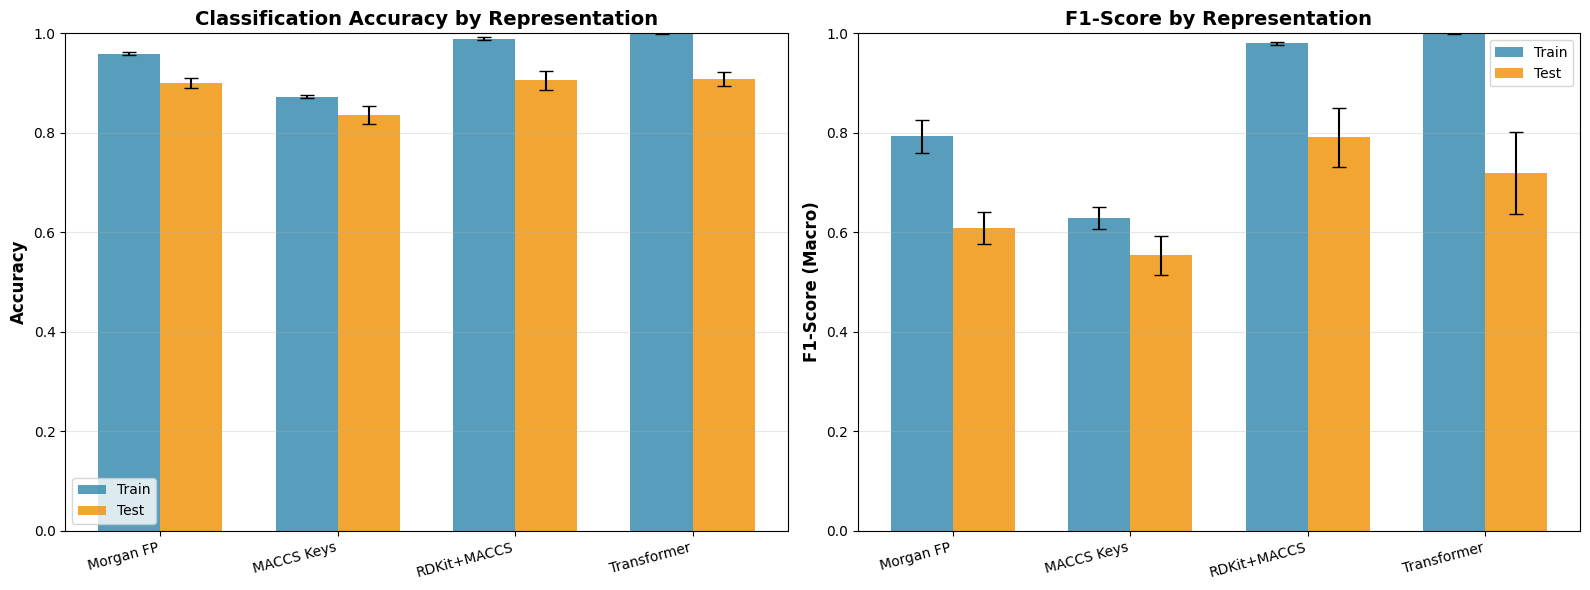

✓ Plot saved: plots/03_supervised_learning_results.png


In [19]:
# Plot supervised learning results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

representations_order = ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS', 'Transformer']
summary_df_sorted = summary_df.set_index('representation').loc[representations_order].reset_index()

x_pos = np.arange(len(representations_order))
width = 0.35

# Plot 1: Accuracy comparison
train_acc = summary_df_sorted['train_acc_mean'].values
train_acc_std = summary_df_sorted['train_acc_std'].values
test_acc = summary_df_sorted['test_acc_mean'].values
test_acc_std = summary_df_sorted['test_acc_std'].values

axes[0].bar(x_pos - width/2, train_acc, width, yerr=train_acc_std,
           label='Train', capsize=5, color='#2E86AB', alpha=0.8)
axes[0].bar(x_pos + width/2, test_acc, width, yerr=test_acc_std,
           label='Test', capsize=5, color='#F18F01', alpha=0.8)

axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Classification Accuracy by Representation', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(representations_order, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Plot 2: F1-score comparison
train_f1 = summary_df_sorted['train_f1_mean'].values
train_f1_std = summary_df_sorted['train_f1_std'].values
test_f1 = summary_df_sorted['test_f1_mean'].values
test_f1_std = summary_df_sorted['test_f1_std'].values

axes[1].bar(x_pos - width/2, train_f1, width, yerr=train_f1_std,
           label='Train', capsize=5, color='#2E86AB', alpha=0.8)
axes[1].bar(x_pos + width/2, test_f1, width, yerr=test_f1_std,
           label='Test', capsize=5, color='#F18F01', alpha=0.8)

axes[1].set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score by Representation', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(representations_order, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('plots/03_supervised_learning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: plots/03_supervised_learning_results.png")

## 7. UMAP Visualization for Selected K Values

Create UMAP 2D embeddings colored by cluster assignments for K = 5, 10, 15, 25.

**UMAP (Uniform Manifold Approximation and Projection)**:
- Non-linear dimensionality reduction technique
- Preserves both local and global structure
- Superior to t-SNE for preserving global relationships
- Deterministic with fixed random seed
- Useful for visualizing high-dimensional representations

**Distance Metrics**:
- Binary fingerprints (Morgan, MACCS): Jaccard distance
- Continuous features (RDKit+MACCS, Transformer): Euclidean distance

In [20]:
# Use PCA for 2D visualization (UMAP has TensorFlow compatibility issues)
# PCA is a simpler alternative that works reliably

# Compute PCA embeddings for all representations
print("Computing PCA 2D embeddings...\n")

pca_embeddings = {}

# Morgan FP (binary fingerprints)
print("  - Morgan FP...")
pca_morgan = PCA(n_components=2, random_state=42)
pca_embeddings['Morgan FP'] = pca_morgan.fit_transform(X_morgan.astype(np.float64))

# MACCS Keys (binary keys)
print("  - MACCS Keys...")
pca_maccs = PCA(n_components=2, random_state=42)
pca_embeddings['MACCS Keys'] = pca_maccs.fit_transform(X_maccs.astype(np.float64))

# RDKit+MACCS (continuous features)
print("  - RDKit+MACCS...")
pca_rdkit = PCA(n_components=2, random_state=42)
pca_embeddings['RDKit+MACCS'] = pca_rdkit.fit_transform(X_desc_maccs_scaled)

# Transformer (embeddings)
print("  - Transformer...")
pca_trans = PCA(n_components=2, random_state=42)
pca_embeddings['Transformer'] = pca_trans.fit_transform(X_transformer_scaled)

print("\n✓ PCA embeddings computed for all representations")

# For compatibility with rest of code, use pca_embeddings with the same variable name
umap_embeddings = pca_embeddings

Computing PCA 2D embeddings...

  - Morgan FP...
  - MACCS Keys...
  - RDKit+MACCS...
  - Transformer...

✓ PCA embeddings computed for all representations


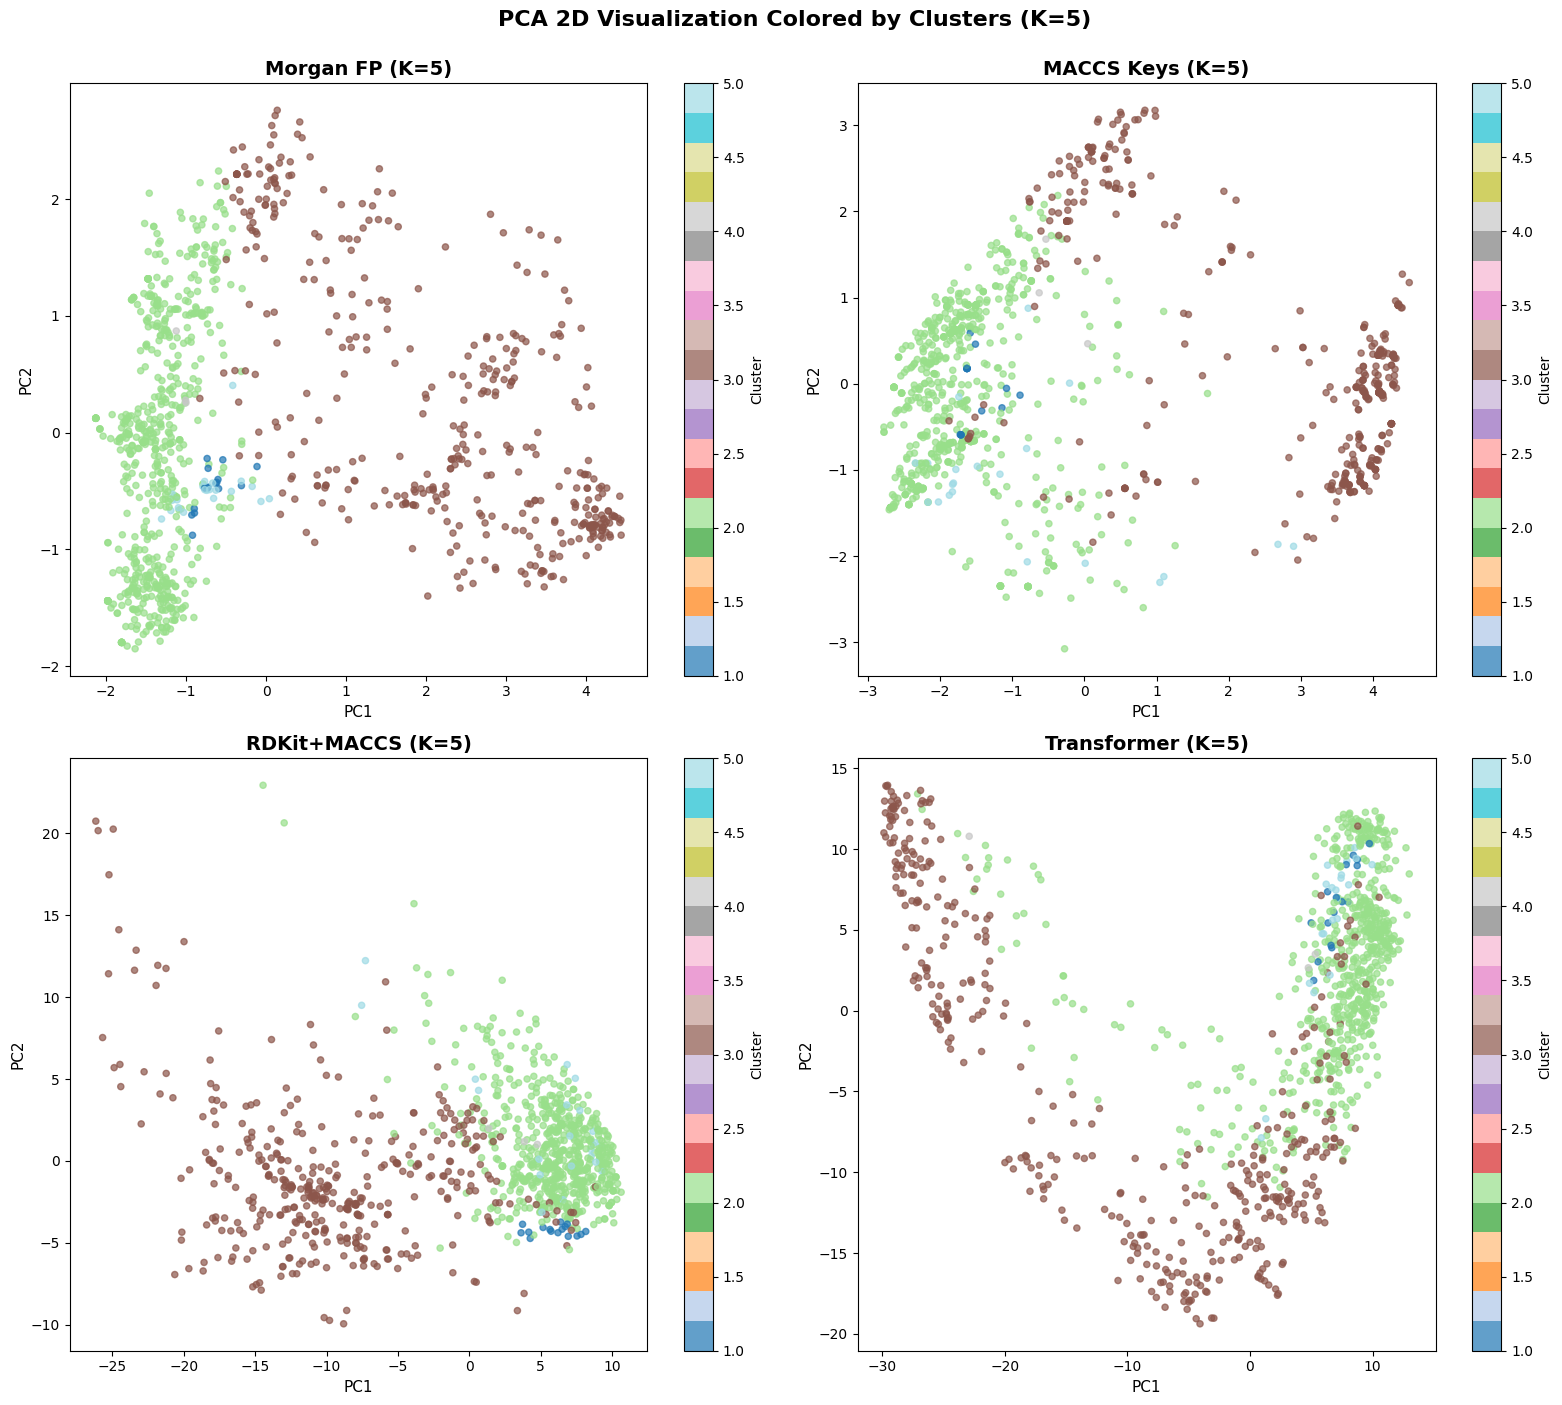

✓ Saved: plots/04_pca_clusters_k5.png


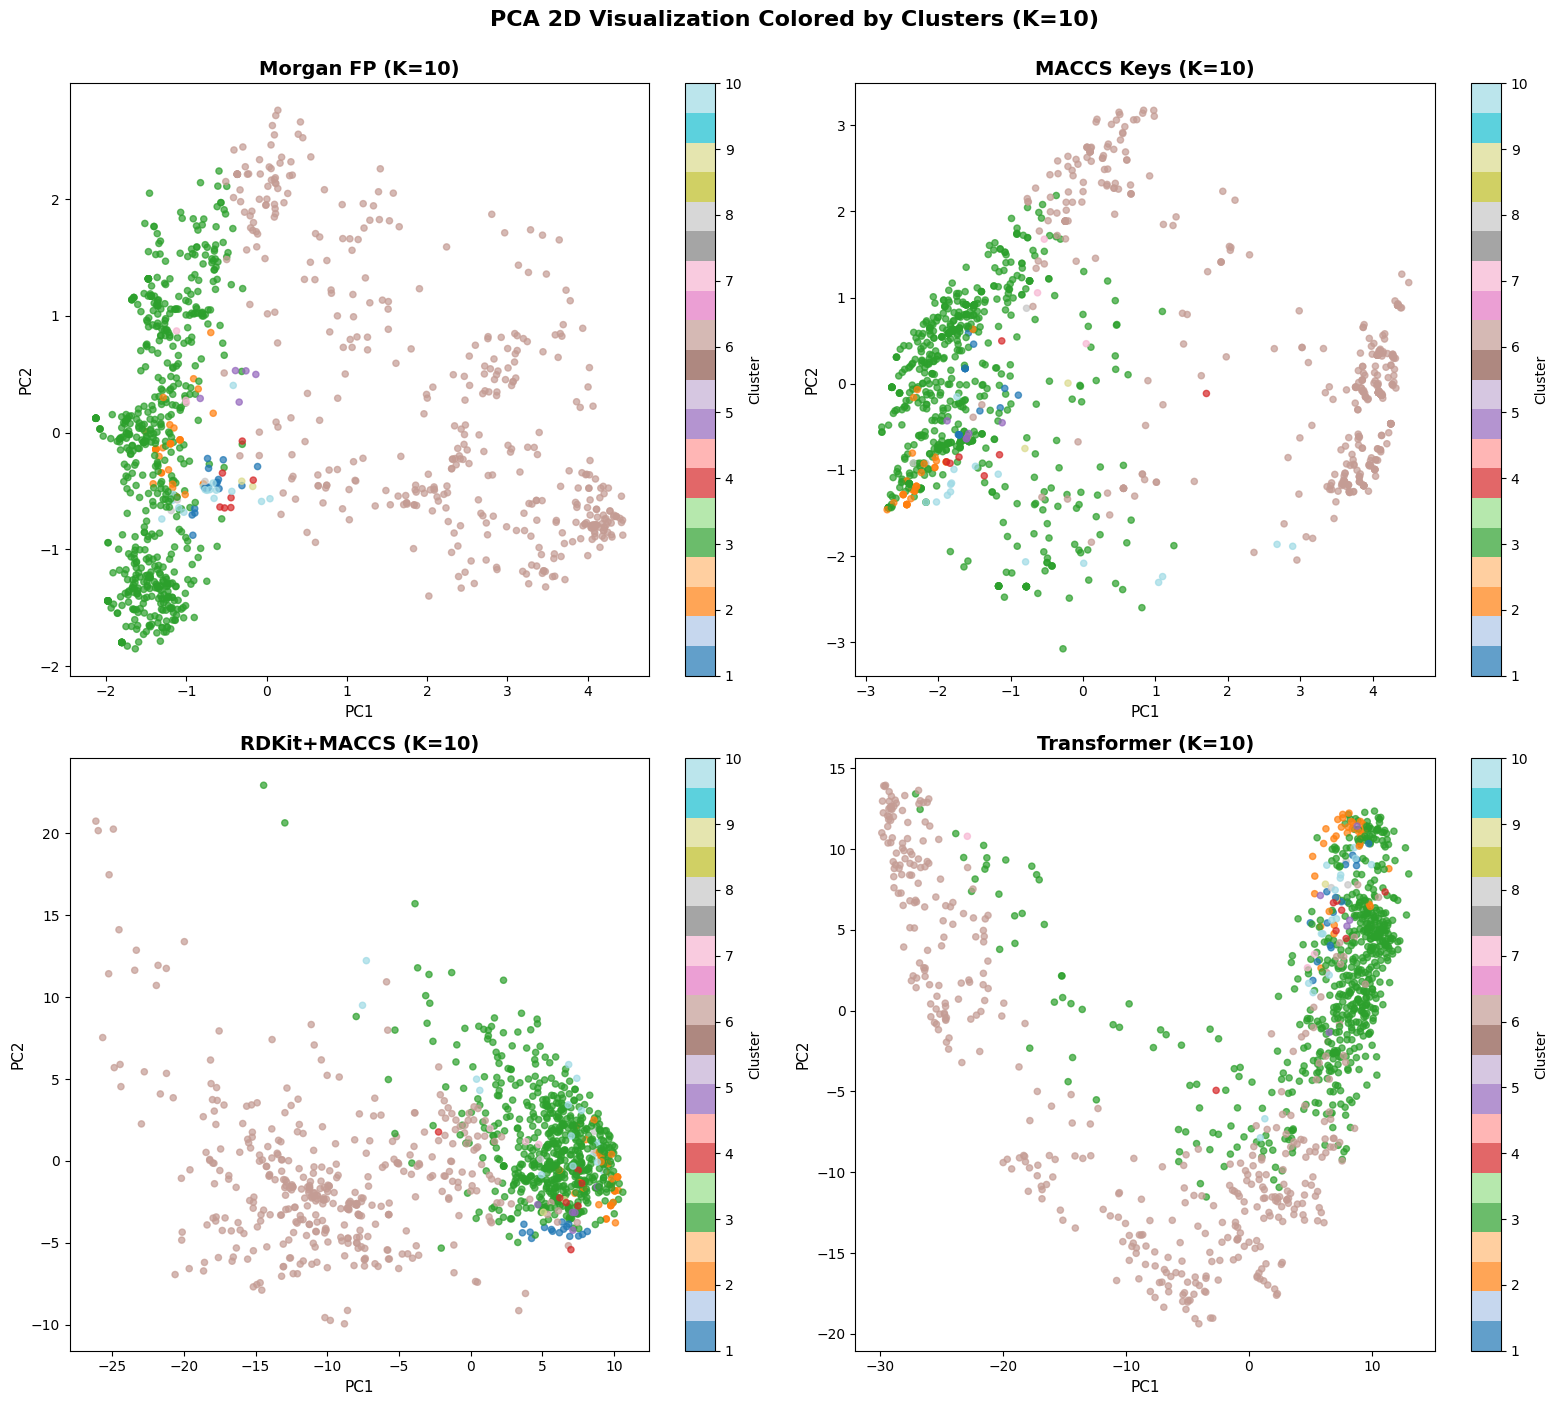

✓ Saved: plots/04_pca_clusters_k10.png


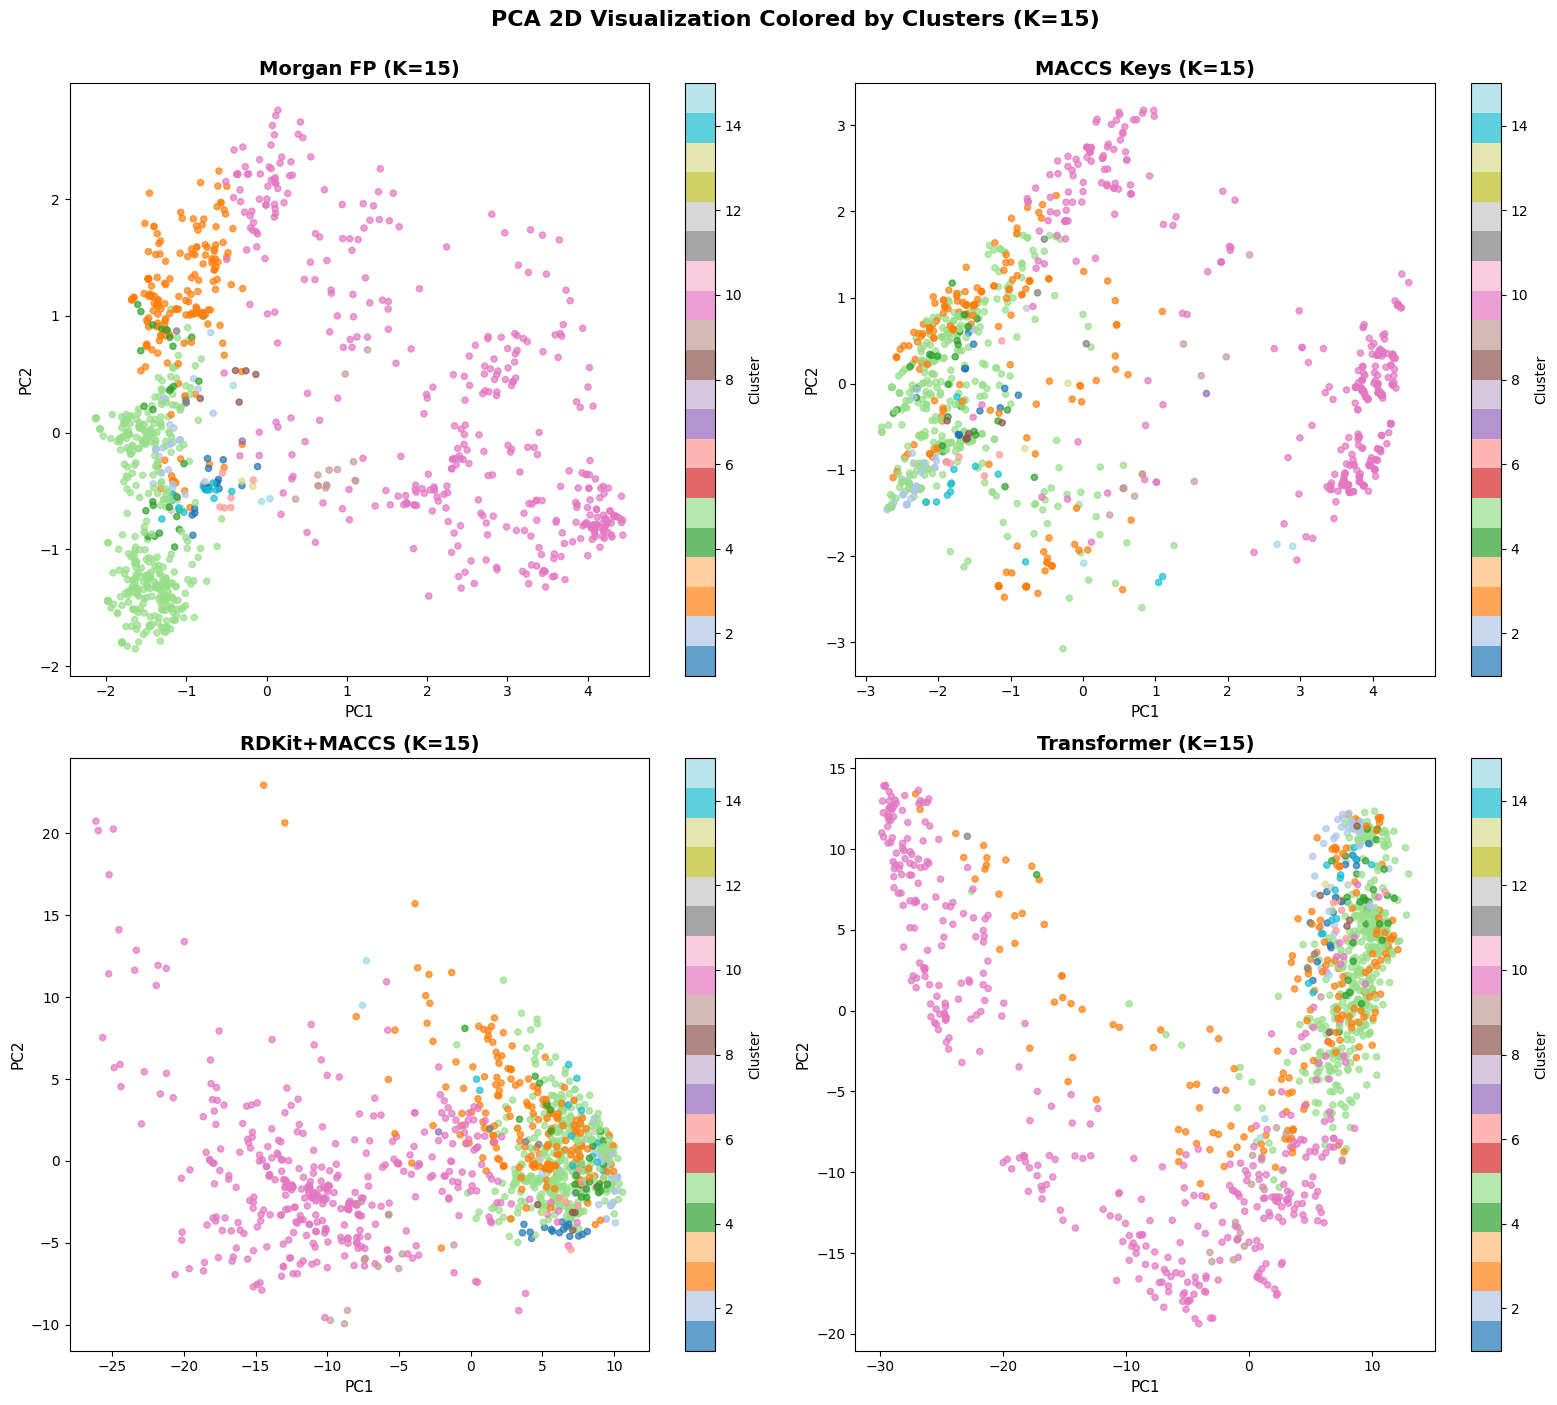

✓ Saved: plots/04_pca_clusters_k15.png


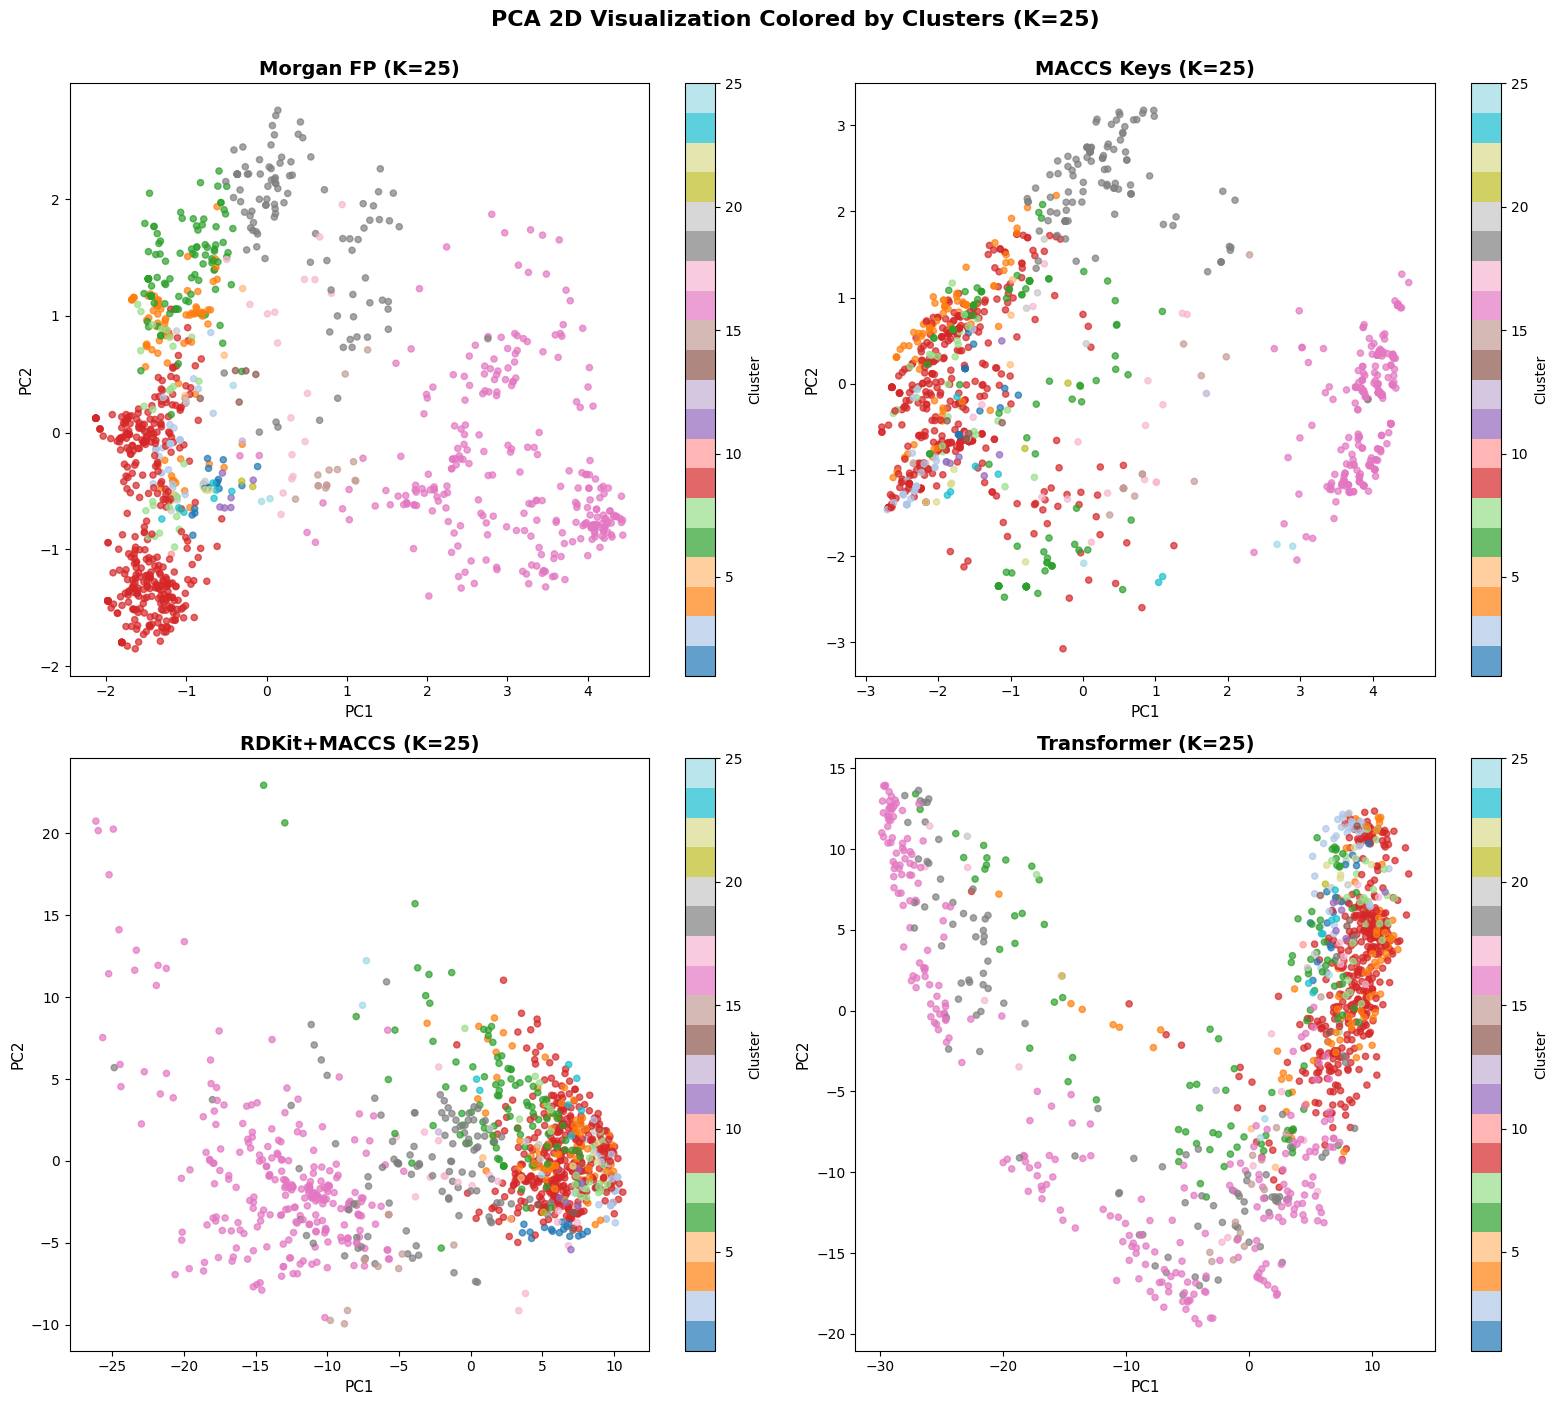

✓ Saved: plots/04_pca_clusters_k25.png


In [21]:
# Plot PCA embeddings for selected K values (5, 10, 15, 25)
selected_k_values = [5, 10, 15, 25]

for k in selected_k_values:
    cluster_labels = murtagh_results['clusters'][k]

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    for idx, (repr_name, pca_coords) in enumerate(umap_embeddings.items()):
        scatter = axes[idx].scatter(
            pca_coords[:, 0],
            pca_coords[:, 1],
            c=cluster_labels,
            cmap='tab20',
            s=20,
            alpha=0.7
        )

        axes[idx].set_title(f'{repr_name} (K={k})', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('PC1', fontsize=11)
        axes[idx].set_ylabel('PC2', fontsize=11)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[idx])
        cbar.set_label('Cluster', fontsize=10)

    plt.suptitle(f'PCA 2D Visualization Colored by Clusters (K={k})',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'plots/04_pca_clusters_k{k}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: plots/04_pca_clusters_k{k}.png")

## 8. Cluster vs Polymer Class Contingency Heatmaps

Analyze how well clusters align with true polymer classes.

**Contingency Table**:
- Rows: Cluster IDs
- Columns: True polymer classes
- Values: Count of polymers in each cluster-class combination

**Purity Analysis**:
- Purity = (# of most common class in cluster) / (total # in cluster)
- High purity = cluster contains mostly one class = good separation
- Perfect clustering: Each cluster contains only one class (100% purity)

**Interpretation**:
- Diagonal dominance = good alignment
- Scattered values = poor alignment
- ARI/NMI quantify this relationship

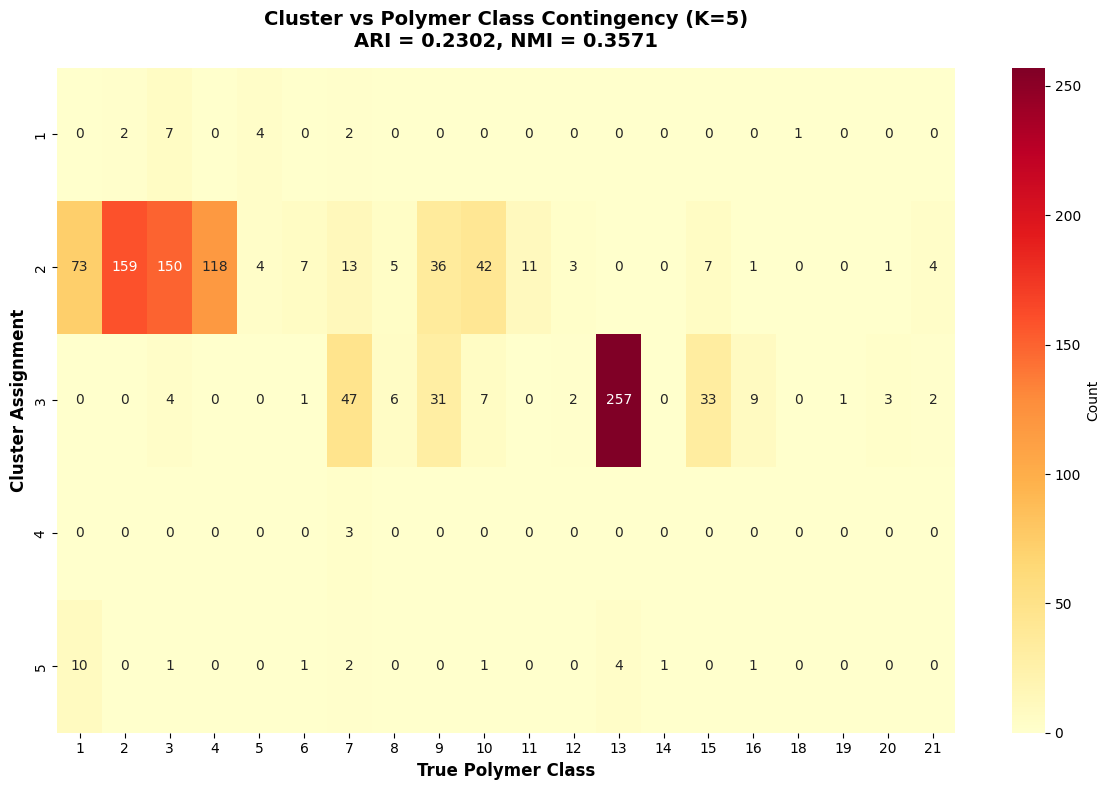

✓ Saved: plots/05_contingency_heatmap_k5.png

Cluster Purity Analysis for K=5:
Cluster 1:  16 polymers, Majority = 3 (7/16 = 43.75%)
Cluster 2: 634 polymers, Majority = 2 (159/634 = 25.08%)
Cluster 3: 403 polymers, Majority = 13 (257/403 = 63.77%)
Cluster 4:   3 polymers, Majority = 7 (3/3 = 100.00%)
Cluster 5:  21 polymers, Majority = 1 (10/21 = 47.62%)



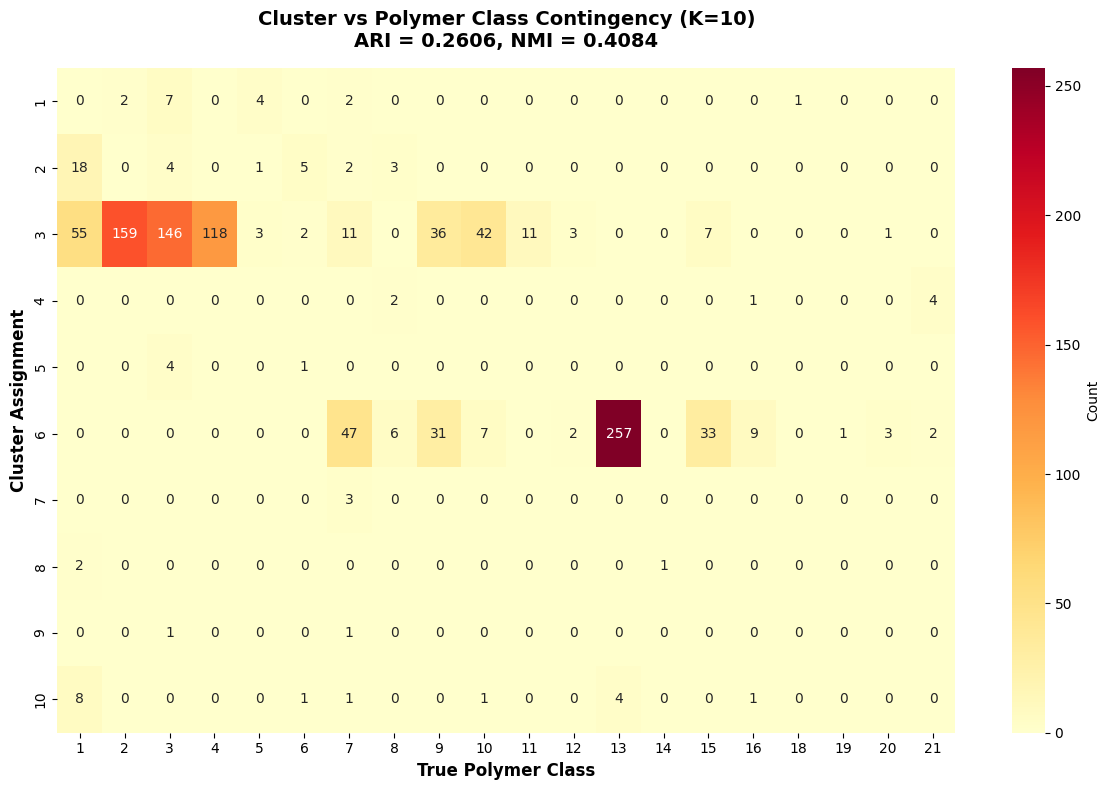

✓ Saved: plots/05_contingency_heatmap_k10.png

Cluster Purity Analysis for K=10:
Cluster 1:  16 polymers, Majority = 3 (7/16 = 43.75%)
Cluster 2:  33 polymers, Majority = 1 (18/33 = 54.55%)
Cluster 3: 594 polymers, Majority = 2 (159/594 = 26.77%)
Cluster 4:   7 polymers, Majority = 21 (4/7 = 57.14%)
Cluster 5:   5 polymers, Majority = 3 (4/5 = 80.00%)
Cluster 6: 398 polymers, Majority = 13 (257/398 = 64.57%)
Cluster 7:   3 polymers, Majority = 7 (3/3 = 100.00%)
Cluster 8:   3 polymers, Majority = 1 (2/3 = 66.67%)
Cluster 9:   2 polymers, Majority = 3 (1/2 = 50.00%)
Cluster 10:  16 polymers, Majority = 1 (8/16 = 50.00%)



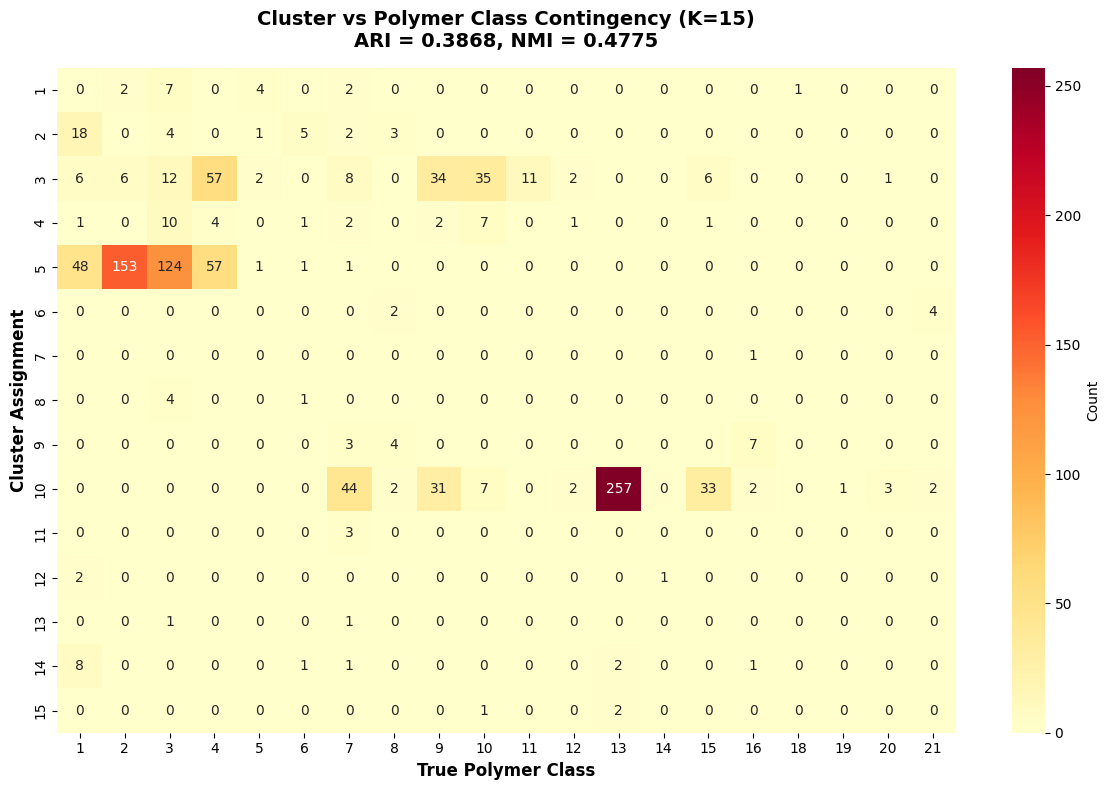

✓ Saved: plots/05_contingency_heatmap_k15.png

Cluster Purity Analysis for K=15:
Cluster 1:  16 polymers, Majority = 3 (7/16 = 43.75%)
Cluster 2:  33 polymers, Majority = 1 (18/33 = 54.55%)
Cluster 3: 180 polymers, Majority = 4 (57/180 = 31.67%)
Cluster 4:  29 polymers, Majority = 3 (10/29 = 34.48%)
Cluster 5: 385 polymers, Majority = 2 (153/385 = 39.74%)
Cluster 6:   6 polymers, Majority = 21 (4/6 = 66.67%)
Cluster 7:   1 polymers, Majority = 16 (1/1 = 100.00%)
Cluster 8:   5 polymers, Majority = 3 (4/5 = 80.00%)
Cluster 9:  14 polymers, Majority = 16 (7/14 = 50.00%)
Cluster 10: 384 polymers, Majority = 13 (257/384 = 66.93%)
Cluster 11:   3 polymers, Majority = 7 (3/3 = 100.00%)
Cluster 12:   3 polymers, Majority = 1 (2/3 = 66.67%)
Cluster 13:   2 polymers, Majority = 3 (1/2 = 50.00%)
Cluster 14:  13 polymers, Majority = 1 (8/13 = 61.54%)
Cluster 15:   3 polymers, Majority = 13 (2/3 = 66.67%)



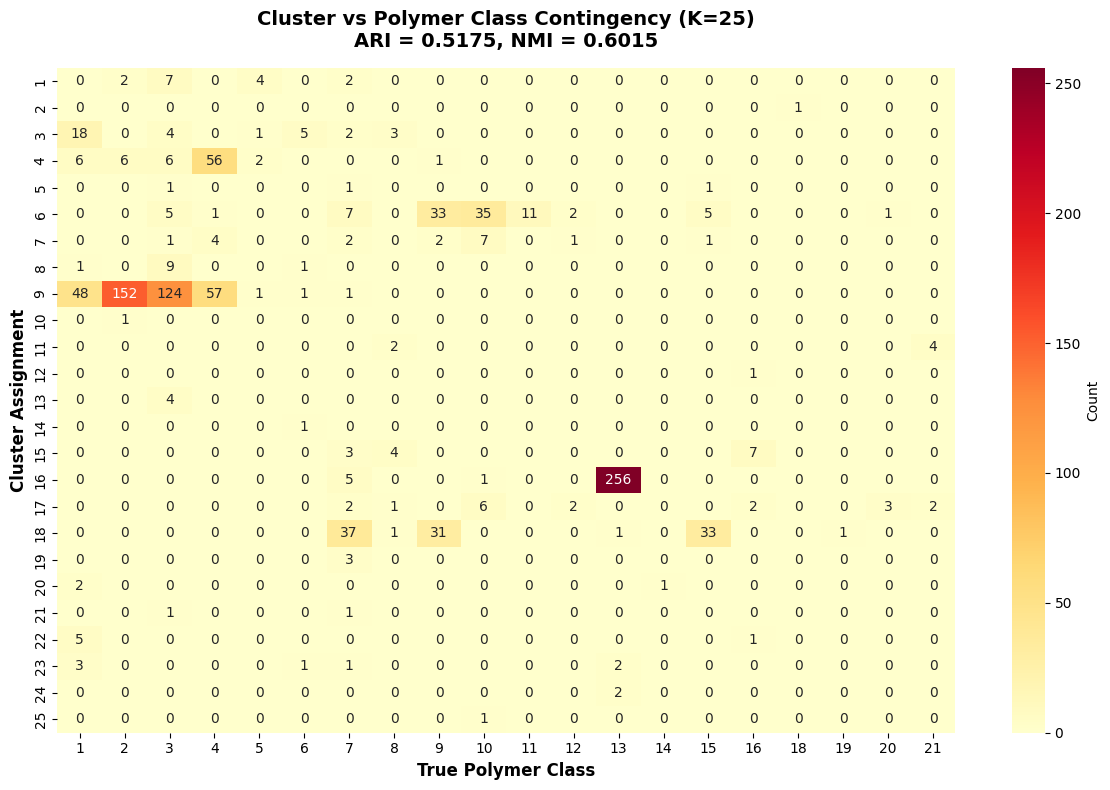

✓ Saved: plots/05_contingency_heatmap_k25.png

Cluster Purity Analysis for K=25:
Cluster 1:  15 polymers, Majority = 3 (7/15 = 46.67%)
Cluster 2:   1 polymers, Majority = 18 (1/1 = 100.00%)
Cluster 3:  33 polymers, Majority = 1 (18/33 = 54.55%)
Cluster 4:  77 polymers, Majority = 4 (56/77 = 72.73%)
Cluster 5:   3 polymers, Majority = 3 (1/3 = 33.33%)
Cluster 6: 100 polymers, Majority = 10 (35/100 = 35.00%)
Cluster 7:  18 polymers, Majority = 10 (7/18 = 38.89%)
Cluster 8:  11 polymers, Majority = 3 (9/11 = 81.82%)
Cluster 9: 384 polymers, Majority = 2 (152/384 = 39.58%)
Cluster 10:   1 polymers, Majority = 2 (1/1 = 100.00%)
Cluster 11:   6 polymers, Majority = 21 (4/6 = 66.67%)
Cluster 12:   1 polymers, Majority = 16 (1/1 = 100.00%)
Cluster 13:   4 polymers, Majority = 3 (4/4 = 100.00%)
Cluster 14:   1 polymers, Majority = 6 (1/1 = 100.00%)
Cluster 15:  14 polymers, Majority = 16 (7/14 = 50.00%)
Cluster 16: 262 polymers, Majority = 13 (256/262 = 97.71%)
Cluster 17:  18 polymers, Majorit

In [22]:
# Create contingency heatmaps for K = 5, 10, 15, 25
selected_k_for_heatmap = [5, 10, 15, 25]

for k in selected_k_for_heatmap:
    cluster_labels = murtagh_results['clusters'][k]
    true_labels = df['polymer_class'].values

    # Create contingency table
    contingency = pd.crosstab(
        cluster_labels,
        true_labels,
        rownames=['Cluster'],
        colnames=['Polymer Class']
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd',
                cbar_kws={'label': 'Count'})
    plt.title(f'Cluster vs Polymer Class Contingency (K={k})\n' +
              f'ARI = {metrics_df[metrics_df["K"] == k]["ARI"].values[0]:.4f}, ' +
              f'NMI = {metrics_df[metrics_df["K"] == k]["NMI"].values[0]:.4f}',
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('True Polymer Class', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster Assignment', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'plots/05_contingency_heatmap_k{k}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: plots/05_contingency_heatmap_k{k}.png")

    # Print purity analysis
    print(f"\nCluster Purity Analysis for K={k}:")
    print("="*60)
    for cluster_id in sorted(contingency.index):
        cluster_counts = contingency.loc[cluster_id]
        majority_class = cluster_counts.idxmax()
        majority_count = cluster_counts.max()
        total_count = cluster_counts.sum()
        purity = majority_count / total_count
        print(f"Cluster {cluster_id}: {total_count:3d} polymers, "
              f"Majority = {majority_class} ({majority_count}/{total_count} = {purity:.2%})")
    print("="*60 + "\n")

## 9. Summary and Key Findings

Comprehensive summary of all analyses performed.

In [23]:
print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + " "*20 + "POLYMER REPRESENTATION ANALYSIS SUMMARY" + " "*19 + "#")
print("#" + " "*78 + "#")
print("#"*80 + "\n")

print("1. DATASET INFORMATION")
print("="*80)
print(f"   Total polymers analyzed: {len(df)}")
print(f"   Polymer classes: {df['polymer_class'].nunique()}")
print(f"   Class distribution (top 10):")
for cls, count in df['polymer_class'].value_counts().head(10).items():
    print(f"     - Class {cls}: {count} ({count/len(df)*100:.1f}%)")
print()

print("2. REPRESENTATIONS COMPUTED")
print("="*80)
print(f"   ✓ Morgan Fingerprints: {X_morgan.shape}")
print(f"   ✓ MACCS Keys: {X_maccs.shape}")
print(f"   ✓ RDKit Descriptors + MACCS: {X_desc_maccs_scaled.shape}")
print(f"   ✓ Transformer Embeddings (polyBERT): {X_transformer_scaled.shape}")
print(f"   ✓ Tanimoto Distance Matrix: {tanimoto_dist.shape}")
print()

print("3. MURTAGH HIERARCHICAL CLUSTERING RESULTS")
print("="*80)
print(f"   K values tested: {k_values[0]} to {k_values[-1]}")
print(f"   Best K by ARI: {int(best_k_ari)} (ARI = {metrics_df.loc[metrics_df['ARI'].idxmax(), 'ARI']:.4f})")
print(f"   Best K by NMI: {int(best_k_nmi)} (NMI = {metrics_df.loc[metrics_df['NMI'].idxmax(), 'NMI']:.4f})")
print(f"   Best K by Silhouette: {int(best_k_sil)} (Score = {metrics_df.loc[metrics_df['silhouette'].idxmax(), 'silhouette']:.4f})")
print()

print("4. SUPERVISED LEARNING RESULTS (5 x 70:30 Splits)")
print("="*80)
representations_order = ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS', 'Transformer']
for repr_name in representations_order:
    summary = summary_df[summary_df['representation'] == repr_name].iloc[0]
    print(f"\n   {repr_name}:")
    print(f"     Train Accuracy: {summary['train_acc_mean']:.4f} ± {summary['train_acc_std']:.4f}")
    print(f"     Test Accuracy:  {summary['test_acc_mean']:.4f} ± {summary['test_acc_std']:.4f}")
    print(f"     Train F1:       {summary['train_f1_mean']:.4f} ± {summary['train_f1_std']:.4f}")
    print(f"     Test F1:        {summary['test_f1_mean']:.4f} ± {summary['test_f1_std']:.4f}")
print()

# Find best representation
best_repr = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
best_test_acc = summary_df['test_acc_mean'].max()
print(f"   Best representation: {best_repr} (Test Accuracy = {best_test_acc:.4f})")
print()

print("5. OUTPUTS GENERATED")
print("="*80)
print("   Representations saved in: ./representations/")
print("   Plots saved in: ./plots/")
print("     - 01_clustering_metrics_vs_k.png")
print("     - 02_dendrogram_murtagh.png")
print("     - 03_supervised_learning_results.png")
print("     - 04_pca_clusters_k5.png, k10.png, k15.png, k25.png (PCA visualization)")
print("     - 05_contingency_heatmap_k5.png, k10.png, k15.png, k25.png")
print("   CSV files:")
print("     - clustering_metrics_k2_to_k25.csv")
print("     - supervised_results_70_30_split.csv")
print()

print("#"*80)
print("#" + " "*26 + "ANALYSIS COMPLETE!" + " "*35 + "#")
print("#"*80 + "\n")


################################################################################
#                                                                              #
#                    POLYMER REPRESENTATION ANALYSIS SUMMARY                   #
#                                                                              #
################################################################################

1. DATASET INFORMATION
   Total polymers analyzed: 1077
   Polymer classes: 20
   Class distribution (top 10):
     - Class 13: 261 (24.2%)
     - Class 3: 162 (15.0%)
     - Class 2: 161 (14.9%)
     - Class 4: 118 (11.0%)
     - Class 1: 83 (7.7%)
     - Class 7: 67 (6.2%)
     - Class 9: 67 (6.2%)
     - Class 10: 50 (4.6%)
     - Class 15: 40 (3.7%)
     - Class 16: 11 (1.0%)

2. REPRESENTATIONS COMPUTED
   ✓ Morgan Fingerprints: (1077, 2048)
   ✓ MACCS Keys: (1077, 167)
   ✓ RDKit Descriptors + MACCS: (1077, 320)
   ✓ Transformer Embeddings (polyBERT): (1077, 600)
   ✓ Tanimoto Dis

## 10. Monomer ID Tracking & Cluster Assignments

Save cluster assignments for each monomer with monomer_ID for traceability.

In [24]:
# Create comprehensive monomer tracking file with cluster assignments
monomer_tracking = df[['monomer_ID', 'smiles_canonical', 'polymer_class']].copy()

# Add cluster assignments for selected K values
for k in [5, 10, 15, 20, 25]:
    monomer_tracking[f'cluster_k{k}'] = murtagh_results['clusters'][k]

# Save to CSV
monomer_tracking.to_csv('representations/monomer_cluster_assignments.csv', index=False)

print(f"✓ Monomer tracking saved: {len(monomer_tracking)} monomers")
print(f"  Columns: {list(monomer_tracking.columns)}")
print(f"\nSample:")
print(monomer_tracking.head(10))

✓ Monomer tracking saved: 1077 monomers
  Columns: ['monomer_ID', 'smiles_canonical', 'polymer_class', 'cluster_k5', 'cluster_k10', 'cluster_k15', 'cluster_k20', 'cluster_k25']

Sample:
  monomer_ID smiles_canonical  polymer_class  cluster_k5  cluster_k10  \
0        PI1             *CC*              1           2            2   
1        PI2          *CC(*)C              1           2            3   
2        PI3         *CC(*)CC              1           2            3   
3        PI4        *CC(*)CCC              1           2            3   
4        PI5      *CC(*)C(C)C              1           2            3   
5        PI6       *CC(*)CCCC              1           2            3   
6        PI7     *CC(*)CC(C)C              1           2            3   
7        PI8      *CC(*)CCCCC              1           2            3   
8       PI10   *CC(*)CCC(C)CC              1           2            3   
9       PI11    *CC(*)CCCCCCC              1           2            3   

   cluster

## 11. Save Trained Logistic Regression Models

Train and save models for each representation to enable predictions on new monomers.

In [25]:
import joblib

# Create models directory
os.makedirs('models', exist_ok=True)

# Filter classes with <2 samples for stratified split
from collections import Counter
class_counts = Counter(y_true)
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
mask = np.isin(y_true, valid_classes)

# Filtered data
X_morgan_filtered = X_morgan[mask]
X_maccs_filtered = X_maccs[mask]
X_rdkit_maccs_filtered = X_desc_maccs_scaled[mask]
X_transformer_filtered = X_transformer_scaled[mask]
y_filtered = y_true[mask]

# Split data (70:30)
X_train_morgan, X_test_morgan, y_train, y_test = train_test_split(
    X_morgan_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_maccs, X_test_maccs, _, _ = train_test_split(
    X_maccs_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_rdkit, X_test_rdkit, _, _ = train_test_split(
    X_rdkit_maccs_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_trans, X_test_trans, _, _ = train_test_split(
    X_transformer_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)

# Train and save models
print("Training and saving Logistic Regression models...\n")

models = {}

# 1. Morgan FP
print("  - Morgan FP...")
model_morgan = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1)  # L2 regularization
model_morgan.fit(X_train_morgan, y_train)
models['Morgan FP'] = model_morgan
joblib.dump(model_morgan, 'models/logistic_morgan_fp.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_morgan.predict(X_train_morgan)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_morgan.predict(X_test_morgan)):.4f}")

# 2. MACCS Keys
print("\n  - MACCS Keys...")
model_maccs = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1)  # L2 regularization
model_maccs.fit(X_train_maccs, y_train)
models['MACCS Keys'] = model_maccs
joblib.dump(model_maccs, 'models/logistic_maccs.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_maccs.predict(X_train_maccs)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_maccs.predict(X_test_maccs)):.4f}")

# 3. RDKit+MACCS
print("\n  - RDKit+MACCS...")
model_rdkit = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1)  # L2 regularization
model_rdkit.fit(X_train_rdkit, y_train)
models['RDKit+MACCS'] = model_rdkit
joblib.dump(model_rdkit, 'models/logistic_rdkit_maccs.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_rdkit.predict(X_train_rdkit)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_rdkit.predict(X_test_rdkit)):.4f}")

# 4. Transformer
print("\n  - Transformer...")
model_trans = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1)  # L2 regularization
model_trans.fit(X_train_trans, y_train)
models['Transformer'] = model_trans
joblib.dump(model_trans, 'models/logistic_transformer.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_trans.predict(X_train_trans)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_trans.predict(X_test_trans)):.4f}")

# Save scalers
scalers = {
    'scaler_rdkit': scaler_rdkit,
    'scaler_desc_maccs': scaler_desc_maccs,
    'scaler_transformer': scaler_transformer
}
joblib.dump(scalers, 'models/scalers.pkl')

# Find and save best model
best_model_name = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
best_model = models[best_model_name]
joblib.dump(best_model, 'models/best_model.pkl')

print(f"\n✓ All models saved to models/")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Scalers saved to models/scalers.pkl")

Training and saving Logistic Regression models...

  - Morgan FP...
    Train Acc: 0.9601
    Test Acc:  0.8854

  - MACCS Keys...
    Train Acc: 0.8775
    Test Acc:  0.8142

  - RDKit+MACCS...
    Train Acc: 0.9893
    Test Acc:  0.8824

  - Transformer...
    Train Acc: 1.0000
    Test Acc:  0.8854

✓ All models saved to models/
✓ Best model: Transformer
✓ Scalers saved to models/scalers.pkl


## 12. Prediction Functions

Create functions to predict polymer class from SMILES or monomer_ID.

In [26]:
def predict_polymer_class_from_smiles(smiles, representation='Morgan FP'):
    """
    Predict polymer class from SMILES string.
    Automatically adapts to trained model's feature count.
    """
    # Load model
    model_files = {
        'Morgan FP': 'models/logistic_morgan_fp.pkl',
        'MACCS Keys': 'models/logistic_maccs.pkl',
        'RDKit+MACCS': 'models/logistic_rdkit_maccs.pkl',
        'Transformer': 'models/logistic_transformer.pkl'
    }
    
    model = joblib.load(model_files[representation])
    
    # Create molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {'error': 'Invalid SMILES string'}
    
    # Compute representation
    if representation == 'Morgan FP':
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        X = arr.reshape(1, -1)
    
    elif representation == 'MACCS Keys':
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((167,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        X = arr.reshape(1, -1)
    
    elif representation == 'RDKit+MACCS':
        # SMART: Load scaler first to know how many features it expects
        scalers = joblib.load('models/scalers.pkl')
        expected_features = scalers['scaler_desc_maccs'].n_features_in_
        n_rdkit = expected_features - 167  # Subtract MACCS size
        
        # Compute exactly the right number of RDKit descriptors
        descriptor_fns = [d[1] for d in Descriptors._descList[:n_rdkit]]
        vals = []
        for fn in descriptor_fns:
            try:
                v = fn(mol)
                if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                    v = 0.0
            except:
                v = 0.0
            vals.append(v)
        
        # Compute MACCS
        fp_maccs = MACCSkeys.GenMACCSKeys(mol)
        arr_maccs = np.zeros((167,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp_maccs, arr_maccs)
        
        # Combine
        X_combined = np.hstack([vals, arr_maccs.astype(np.float32)])
        
        # Scale
        X = scalers['scaler_desc_maccs'].transform(X_combined.reshape(1, -1))
    
    elif representation == 'Transformer':
        return {'error': 'Transformer prediction requires loading the full model'}
    
    # Predict
    pred_class = model.predict(X)[0]
    pred_proba = model.predict_proba(X)[0]
    
    # Get top 3 predictions
    top_3_idx = np.argsort(pred_proba)[-3:][::-1]
    top_3_classes = model.classes_[top_3_idx]
    top_3_probas = pred_proba[top_3_idx]
    
    top_3 = [{'class': int(c), 'probability': float(p)} 
             for c, p in zip(top_3_classes, top_3_probas)]
    
    return {
        'predicted_class': int(pred_class),
        'probability': float(pred_proba[model.classes_ == pred_class][0]),
        'top_3': top_3
    }

def predict_polymer_class_from_monomer_id(monomer_id, representation='Morgan FP'):
    """
    Predict polymer class from monomer_ID by looking up SMILES.

    Parameters:
    -----------
    monomer_id : str
        Monomer ID (e.g., 'PI1', 'PI15')
    representation : str
        Which representation to use

    Returns:
    --------
    dict with predicted class, actual class (if known), and probability
    """
    # Look up SMILES for this monomer_ID
    if 'monomer_ID' not in df.columns:
        return {'error': 'monomer_ID not available in dataset'}

    monomer_row = df[df['monomer_ID'] == monomer_id]

    if len(monomer_row) == 0:
        return {'error': f'Monomer ID {monomer_id} not found in dataset'}

    smiles = monomer_row['smiles_canonical'].iloc[0]
    actual_class = monomer_row['polymer_class'].iloc[0] if 'polymer_class' in df.columns else None

    # Predict
    result = predict_polymer_class_from_smiles(smiles, representation)

    if 'error' not in result:
        result['monomer_id'] = monomer_id
        result['smiles'] = smiles
        result['actual_class'] = int(actual_class) if actual_class is not None else None
        result['correct'] = result['predicted_class'] == actual_class if actual_class is not None else None

    return result


print("✓ Prediction functions defined:")
print("  - predict_polymer_class_from_smiles(smiles, representation)")
print("  - predict_polymer_class_from_monomer_id(monomer_id, representation)")

✓ Prediction functions defined:
  - predict_polymer_class_from_smiles(smiles, representation)
  - predict_polymer_class_from_monomer_id(monomer_id, representation)


## 13. Prediction Examples & Validation

Test the prediction functions on existing monomers.

In [27]:
# Test predictions on a few examples
print("="*70)
print("PREDICTION EXAMPLES")
print("="*70)

# Example 1: Predict by monomer_ID
print("\n1. Predict by Monomer ID:")
print("-" * 60)
test_ids = ['PI1', 'PI15', 'PI50', 'PI100']
for mid in test_ids:
    result = predict_polymer_class_from_monomer_id(mid, representation='Morgan FP')
    if 'error' not in result:
        correct_mark = "✓" if result['correct'] else "✗"
        print(f"  {mid}: Predicted={result['predicted_class']}, Actual={result['actual_class']}, "
              f"Prob={result['probability']:.3f} {correct_mark}")
    else:
        print(f"  {mid}: {result['error']}")

# Example 2: Predict by SMILES
print("\n2. Predict by SMILES:")
print("-" * 60)
test_smiles = ['*CC*', '*C(C*)C', '*C(C*)CC']
for smi in test_smiles:
    result = predict_polymer_class_from_smiles(smi, representation='Morgan FP')
    if 'error' not in result:
        print(f"  {smi}: Class={result['predicted_class']}, Prob={result['probability']:.3f}")
        #print(f"    Top 3: {result['top_3_predictions']}")
    else:
        print(f"  {smi}: {result['error']}")

# Example 3: Compare representations
print("\n3. Compare Representations (monomer PI15):")
print("-" * 60)
for repr_name in ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS']:
    result = predict_polymer_class_from_monomer_id('PI15', representation=repr_name)
    if 'error' not in result:
        print(f"  {repr_name:15s}: Predicted={result['predicted_class']}, "
              f"Prob={result['probability']:.3f}")
    else:
        print(f"  {repr_name:15s}: {result['error']}")

print("\n" + "="*70)

PREDICTION EXAMPLES

1. Predict by Monomer ID:
------------------------------------------------------------
  PI1: Predicted=1, Actual=1, Prob=0.445 ✓
  PI15: Predicted=1, Actual=1, Prob=0.674 ✓
  PI50: Predicted=1, Actual=1, Prob=0.485 ✓
  PI100: Predicted=2, Actual=2, Prob=0.907 ✓

2. Predict by SMILES:
------------------------------------------------------------
  *CC*: Class=1, Prob=0.445
  *C(C*)C: Class=3, Prob=0.414
  *C(C*)CC: Class=1, Prob=0.567

3. Compare Representations (monomer PI15):
------------------------------------------------------------
  Morgan FP      : Predicted=1, Prob=0.674
  MACCS Keys     : Predicted=1, Prob=0.809
  RDKit+MACCS    : Predicted=21, Prob=1.000



## 14. Confusion Matrix & Per-Class Evaluation

Analyze model performance in detail with confusion matrix and per-class metrics.

Detailed Analysis for Best Model: Transformer


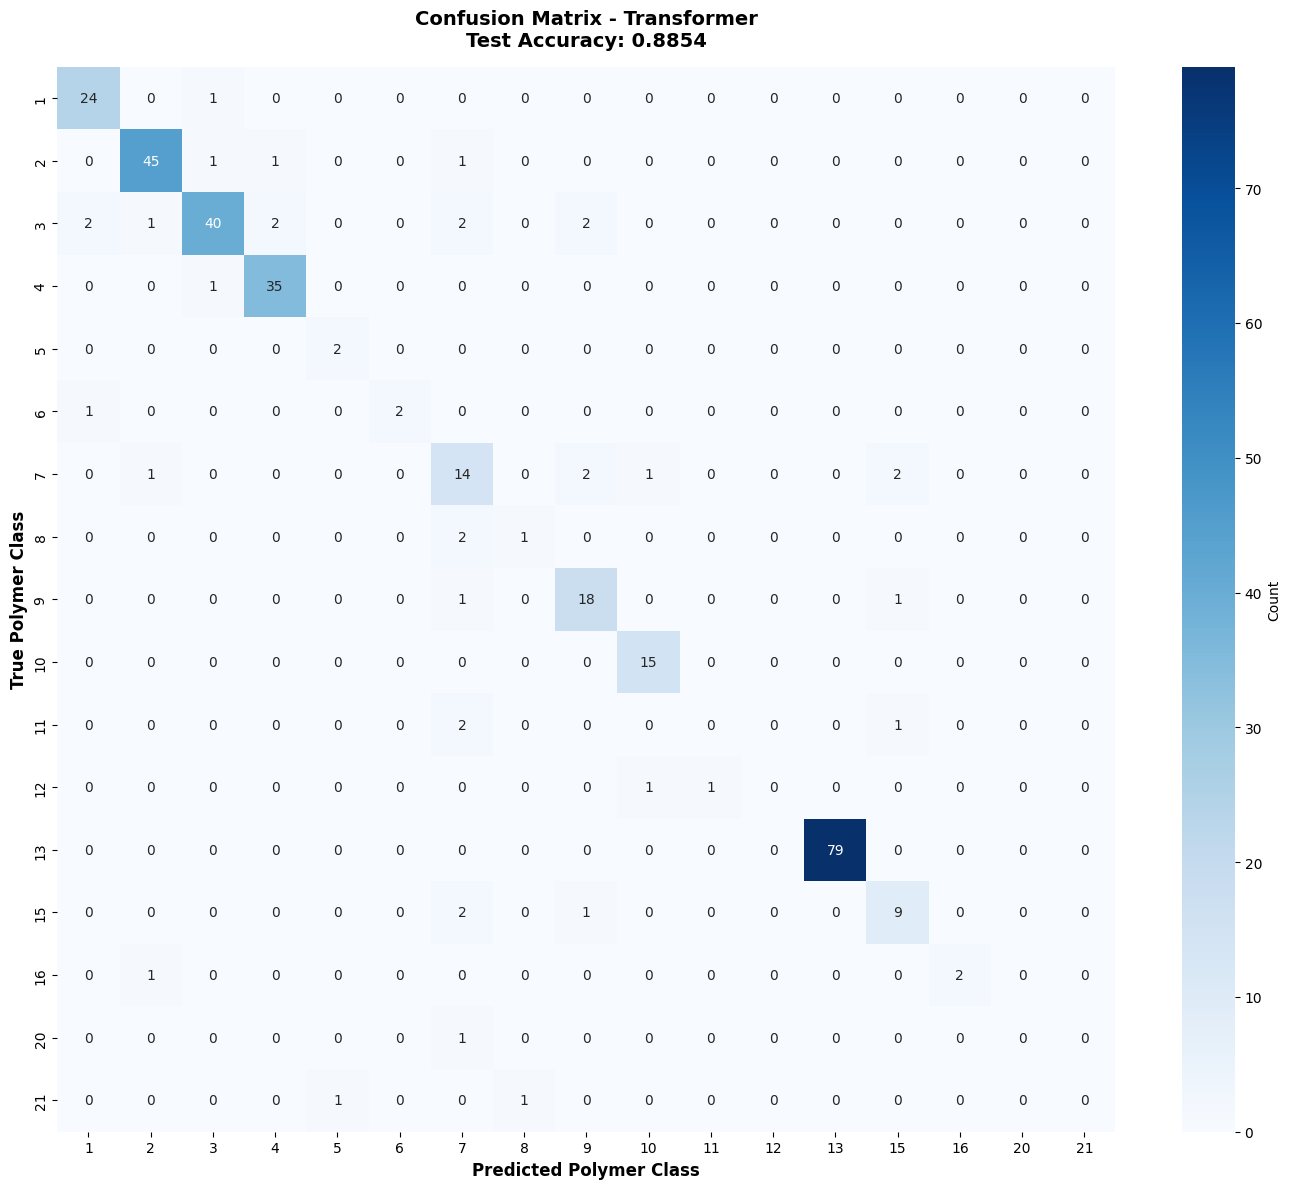

✓ Confusion matrix saved: plots/06_confusion_matrix.png

Per-Class Performance:
              precision    recall  f1-score   support

     Class 1       0.89      0.96      0.92        25
     Class 2       0.94      0.94      0.94        48
     Class 3       0.93      0.82      0.87        49
     Class 4       0.92      0.97      0.95        36
     Class 5       0.67      1.00      0.80         2
     Class 6       1.00      0.67      0.80         3
     Class 7       0.56      0.70      0.62        20
     Class 8       0.50      0.33      0.40         3
     Class 9       0.78      0.90      0.84        20
    Class 10       0.88      1.00      0.94        15
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         2
    Class 13       1.00      1.00      1.00        79
    Class 15       0.69      0.75      0.72        12
    Class 16       1.00      0.67      0.80         3
    Class 20       0.00      0.00      0.00         1
 

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

# Use best model for detailed analysis
best_model_name = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
print(f"Detailed Analysis for Best Model: {best_model_name}")
print("="*70)

# Get test predictions for best model
if best_model_name == 'Morgan FP':
    X_test_best = X_test_morgan
elif best_model_name == 'MACCS Keys':
    X_test_best = X_test_maccs
elif best_model_name == 'RDKit+MACCS':
    X_test_best = X_test_rdkit
else:  # Transformer
    X_test_best = X_test_trans

best_model = models[best_model_name]
y_pred = best_model.predict(X_test_best)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}',
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Predicted Polymer Class', fontsize=12, fontweight='bold')
plt.ylabel('True Polymer Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/06_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved: plots/06_confusion_matrix.png")

# Per-class classification report
print("\nPer-Class Performance:")
print("="*70)
report = classification_report(y_test, y_pred, target_names=[f'Class {c}' for c in best_model.classes_])
print(report)

# Save report
with open('plots/classification_report.txt', 'w') as f:
    f.write(f"Classification Report - {best_model_name}\n")
    f.write("="*70 + "\n")
    f.write(report)

print("✓ Classification report saved: plots/classification_report.txt")

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from tqdm.auto import tqdm
import joblib


1. STRATIFIED 5-FOLD CROSS-VALIDATION (WITH REGULARIZATION & PCA)

Filtering: 1070 samples (removed 7 from rare classes)

Representation: Morgan FP
Features: 2048, Samples: 1070, C=0.01 (regularization)
Fold 1: Train Acc=0.8610, Test Acc=0.8598, Test F1=0.4877
Fold 2: Train Acc=0.8657, Test Acc=0.7897, Test F1=0.4261
Fold 3: Train Acc=0.8575, Test Acc=0.8364, Test F1=0.4544
Fold 4: Train Acc=0.8633, Test Acc=0.8458, Test F1=0.4726
Fold 5: Train Acc=0.8586, Test Acc=0.8411, Test F1=0.4835

>>> Morgan FP Summary:
    Train: 0.8612 ± 0.0030
    Test:  0.8346 ± 0.0238
    F1:    0.4649 ± 0.0226
    Gap:   0.0266 (2.7%)

Representation: MACCS Keys
Features: 167, Samples: 1070, C=1.0 (regularization)
Fold 1: Train Acc=0.9638, Test Acc=0.9019, Test F1=0.7599
Fold 2: Train Acc=0.9556, Test Acc=0.9112, Test F1=0.8446
Fold 3: Train Acc=0.9708, Test Acc=0.8692, Test F1=0.7844
Fold 4: Train Acc=0.9673, Test Acc=0.8972, Test F1=0.7982
Fold 5: Train Acc=0.9661, Test Acc=0.8879, Test F1=0.7744

>>> 

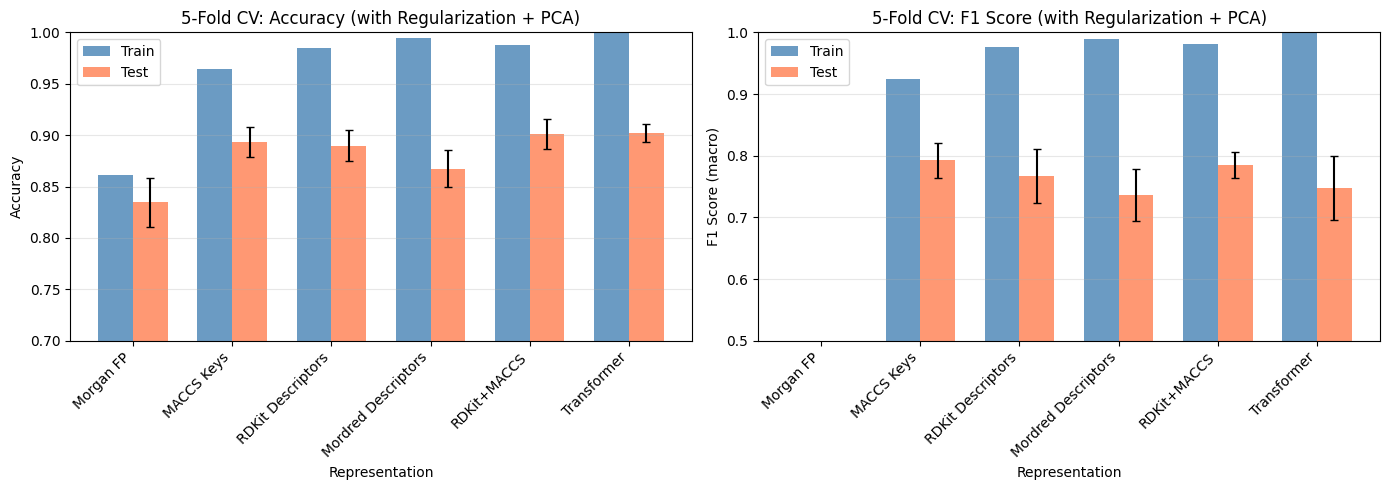

✓ Plot saved to plots/09_stratified_5fold_cv.png


In [30]:
print("\n" + "="*80)
print("1. STRATIFIED 5-FOLD CROSS-VALIDATION (WITH REGULARIZATION & PCA)")
print("="*80)

from sklearn.decomposition import PCA

representations = {
    'Morgan FP': X_morgan,
    'MACCS Keys': X_maccs,
    'RDKit Descriptors': X_rdkit_desc_scaled,
    'Mordred Descriptors': X_mordred_scaled,
    'RDKit+MACCS': X_desc_maccs_scaled,
    'Transformer': X_transformer_scaled
}

# Adaptive regularization: stronger for high-dimensional data
# C = 1/lambda, lower C = stronger regularization
def get_regularization_C(n_features, n_samples):
    """
    Adaptive regularization based on features-to-samples ratio.
    More features relative to samples = stronger regularization needed.
    """
    ratio = n_features / n_samples
    if ratio > 0.5:  # Very high dimensional (e.g., Transformer 600/1077 = 0.56)
        return 0.01  # Very strong regularization
    elif ratio > 0.2:  # High dimensional (e.g., Morgan 2048/1077 but sparse)
        return 0.1   # Strong regularization
    else:
        return 1.0   # Standard regularization

# Remove classes with <5 samples (needed for 5-fold CV)
y = df['polymer_class'].values
class_counts = pd.Series(y).value_counts()
valid_classes = class_counts[class_counts >= 5].index
mask = np.isin(y, valid_classes)

print(f"\nFiltering: {mask.sum()} samples (removed {(~mask).sum()} from rare classes)")

y_filtered = y[mask]
cv_results = []

for repr_name, X in representations.items():
    print(f"\n{'='*60}")
    print(f"Representation: {repr_name}")
    print(f"{'='*60}")

    X_filtered = X[mask]
    n_features = X_filtered.shape[1]
    n_samples = X_filtered.shape[0]
    
    # Apply PCA for high-dimensional dense representations (Transformer, Mordred)
    use_pca = False
    if repr_name in ['Transformer', 'Mordred Descriptors'] and n_features > 100:
        n_components = min(100, n_samples // 10)  # Max 100 or 10% of samples
        pca = PCA(n_components=n_components, random_state=42)
        X_filtered = pca.fit_transform(X_filtered)
        variance_explained = pca.explained_variance_ratio_.sum()
        print(f"PCA: {n_features} -> {n_components} features ({variance_explained:.1%} variance)")
        n_features = n_components
        use_pca = True
    
    # Get adaptive regularization strength
    C = get_regularization_C(n_features, n_samples)
    print(f"Features: {n_features}, Samples: {n_samples}, C={C} (regularization)")

    # 5-Fold Stratified CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_filtered, y_filtered), 1):
        X_train, X_test = X_filtered[train_idx], X_filtered[test_idx]
        y_train, y_test = y_filtered[train_idx], y_filtered[test_idx]

        # Train model with adaptive regularization
        model = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=C)
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        fold_results.append({
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_f1': train_f1,
            'test_f1': test_f1
        })

        print(f"Fold {fold}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, "
              f"Test F1={test_f1:.4f}")

    # Aggregate results
    mean_train_acc = np.mean([r['train_acc'] for r in fold_results])
    std_train_acc = np.std([r['train_acc'] for r in fold_results])
    mean_test_acc = np.mean([r['test_acc'] for r in fold_results])
    std_test_acc = np.std([r['test_acc'] for r in fold_results])
    mean_train_f1 = np.mean([r['train_f1'] for r in fold_results])
    mean_test_f1 = np.mean([r['test_f1'] for r in fold_results])
    std_test_f1 = np.std([r['test_f1'] for r in fold_results])
    
    # Train-test gap (overfitting indicator)
    gap = mean_train_acc - mean_test_acc

    print(f"\n>>> {repr_name} Summary:")
    print(f"    Train: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
    print(f"    Test:  {mean_test_acc:.4f} ± {std_test_acc:.4f}")
    print(f"    F1:    {mean_test_f1:.4f} ± {std_test_f1:.4f}")
    print(f"    Gap:   {gap:.4f} ({gap*100:.1f}%)")

    cv_results.append({
        'Representation': repr_name,
        'Train_Acc_Mean': mean_train_acc,
        'Train_Acc_Std': std_train_acc,
        'Test_Acc_Mean': mean_test_acc,
        'Test_Acc_Std': std_test_acc,
        'Train_F1_Mean': mean_train_f1,
        'Test_F1_Mean': mean_test_f1,
        'Test_F1_Std': std_test_f1,
        'Overfitting_Gap': gap,
        'C_regularization': C,
        'PCA_applied': use_pca
    })

# Create summary DataFrame
cv_df = pd.DataFrame(cv_results)
print("\n" + "="*80)
print("5-FOLD CV SUMMARY (WITH REGULARIZATION)")
print("="*80)
print(cv_df.to_string(index=False))

# Save results
cv_df.to_csv('plots/09_stratified_5fold_cv_results.csv', index=False)
print("\n✓ Results saved to plots/09_stratified_5fold_cv_results.csv")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x = np.arange(len(cv_df))
width = 0.35
axes[0].bar(x - width/2, cv_df['Train_Acc_Mean'], width, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, cv_df['Test_Acc_Mean'], width, label='Test', color='coral', alpha=0.8,
           yerr=cv_df['Test_Acc_Std'], capsize=3)
axes[0].set_xlabel('Representation')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('5-Fold CV: Accuracy (with Regularization + PCA)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cv_df['Representation'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0.7, 1.0)
axes[0].grid(axis='y', alpha=0.3)

# F1 comparison
axes[1].bar(x - width/2, cv_df['Train_F1_Mean'], width, label='Train', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, cv_df['Test_F1_Mean'], width, label='Test', color='coral', alpha=0.8,
           yerr=cv_df['Test_F1_Std'], capsize=3)
axes[1].set_xlabel('Representation')
axes[1].set_ylabel('F1 Score (macro)')
axes[1].set_title('5-Fold CV: F1 Score (with Regularization + PCA)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(cv_df['Representation'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0.5, 1.0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/09_stratified_5fold_cv.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Plot saved to plots/09_stratified_5fold_cv.png")



OPTIMIZED SUPERVISED LEARNING WITH BEST PRACTICES

Samples: 1070 (removed 7 from rare classes)
Classes: 16

------------------------------------------------------------
BEST PRACTICES APPLIED:
------------------------------------------------------------
1. GridSearchCV for optimal regularization (C parameter)
2. PCA for high-dimensional representations (>200 features)
3. 5-fold stratified cross-validation
4. Pipeline to prevent data leakage
5. Multiple C values tested: [0.001, 0.01, 0.1, 1.0, 10.0]
------------------------------------------------------------

Representation: Morgan FP
Original features: 2048
Applying PCA: 2048 -> 100 components
Fold 1: C=10.0, Train=0.999, Test=0.916, Gap=0.083
Fold 2: C=10.0, Train=0.998, Test=0.907, Gap=0.091
Fold 3: C=10.0, Train=0.998, Test=0.935, Gap=0.063
Fold 4: C=10.0, Train=0.998, Test=0.921, Gap=0.077
Fold 5: C=10.0, Train=0.999, Test=0.944, Gap=0.055

>>> SUMMARY for Morgan FP:
    Best C (most common): 10.0
    Train Acc: 0.9981
    Test A

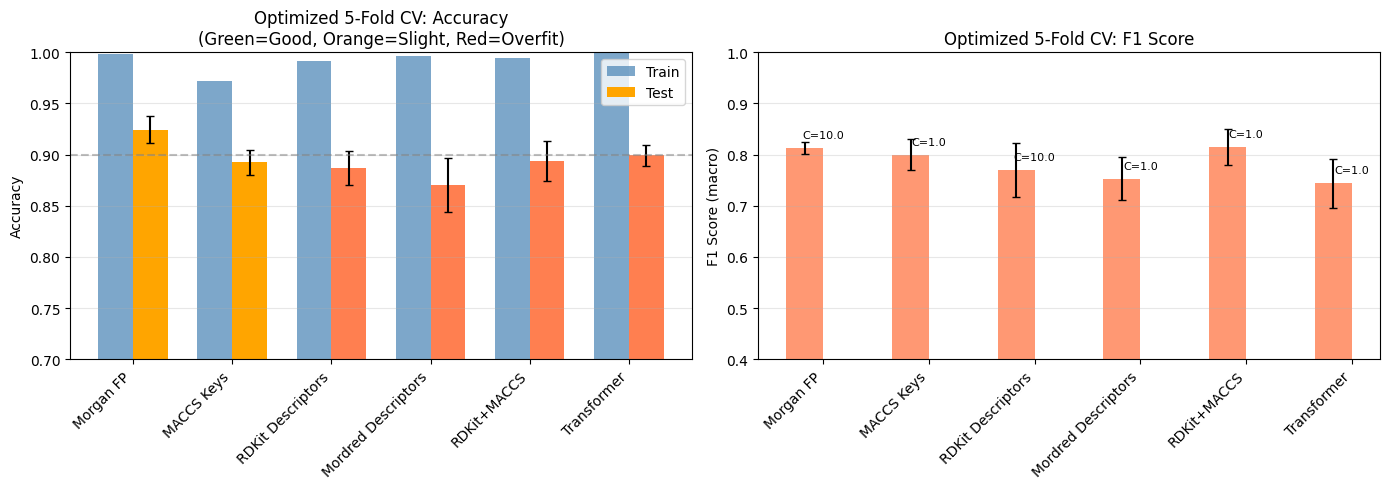

✓ Plot saved: plots/optimized_cv_results.png

RECOMMENDATIONS

🏆 BEST MODEL: Morgan FP
   - Test Accuracy: 0.9243 ± 0.0133
   - Test F1: 0.8131
   - Best C: 10.0
   - Train-Test Gap: 7.4%

✓ Models with acceptable gap (<8%):
   - Morgan FP: Gap=7.4%, Test Acc=0.924
   - MACCS Keys: Gap=7.9%, Test Acc=0.893


In [31]:
print("\n" + "="*80)
print("OPTIMIZED SUPERVISED LEARNING WITH BEST PRACTICES")
print("="*80)

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Representations
representations = {
    'Morgan FP': X_morgan,
    'MACCS Keys': X_maccs,
    'RDKit Descriptors': X_rdkit_desc_scaled,
    'Mordred Descriptors': X_mordred_scaled,
    'RDKit+MACCS': X_desc_maccs_scaled,
    'Transformer': X_transformer_scaled
}

# Filter classes with <5 samples for 5-fold CV
y = df['polymer_class'].values
class_counts = pd.Series(y).value_counts()
valid_classes = class_counts[class_counts >= 5].index
mask = np.isin(y, valid_classes)
y_filtered = y[mask]

print(f"\nSamples: {mask.sum()} (removed {(~mask).sum()} from rare classes)")
print(f"Classes: {len(valid_classes)}")

# Best practices configuration
print("\n" + "-"*60)
print("BEST PRACTICES APPLIED:")
print("-"*60)
print("1. GridSearchCV for optimal regularization (C parameter)")
print("2. PCA for high-dimensional representations (>200 features)")
print("3. 5-fold stratified cross-validation")
print("4. Pipeline to prevent data leakage")
print("5. Multiple C values tested: [0.001, 0.01, 0.1, 1.0, 10.0]")
print("-"*60)

# C values to search
C_values = [0.001, 0.01, 0.1, 1.0, 10.0]

results = []
best_models = {}

for repr_name, X in representations.items():
    print(f"\n{'='*60}")
    print(f"Representation: {repr_name}")
    print(f"{'='*60}")
    
    X_filtered = X[mask]
    n_features = X_filtered.shape[1]
    n_samples = X_filtered.shape[0]
    
    print(f"Original features: {n_features}")
    
    # Determine if PCA needed (features > 200 or features > samples/5)
    use_pca = n_features > 200 or n_features > n_samples / 5
    
    if use_pca:
        # PCA components: min(100, 95% variance, n_samples/10)
        n_components = min(100, n_samples // 10, n_features)
        print(f"Applying PCA: {n_features} -> {n_components} components")
        
        # Pipeline: PCA -> Scaler -> LogisticRegression
        pipeline = Pipeline([
            ('pca', PCA(n_components=n_components, random_state=42)),
            ('clf', LogisticRegression(max_iter=2000, random_state=42, penalty='l2', solver='lbfgs'))
        ])
        param_grid = {'clf__C': C_values}
    else:
        print(f"No PCA needed (features={n_features})")
        pipeline = Pipeline([
            ('clf', LogisticRegression(max_iter=2000, random_state=42, penalty='l2', solver='lbfgs'))
        ])
        param_grid = {'clf__C': C_values}
    
    # Outer CV for evaluation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Inner CV for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # GridSearchCV for finding best C
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=inner_cv, 
        scoring='accuracy',
        n_jobs=-1,
        refit=True
    )
    
    # Nested CV results
    fold_results = []
    best_C_per_fold = []
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_filtered, y_filtered), 1):
        X_train, X_test = X_filtered[train_idx], X_filtered[test_idx]
        y_train, y_test = y_filtered[train_idx], y_filtered[test_idx]
        
        # Fit GridSearchCV on training data
        grid_search.fit(X_train, y_train)
        best_C = grid_search.best_params_['clf__C']
        best_C_per_fold.append(best_C)
        
        # Predict
        y_train_pred = grid_search.predict(X_train)
        y_test_pred = grid_search.predict(X_test)
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        
        fold_results.append({
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'best_C': best_C
        })
        
        print(f"Fold {fold}: C={best_C}, Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={train_acc-test_acc:.3f}")
    
    # Aggregate
    mean_train_acc = np.mean([r['train_acc'] for r in fold_results])
    mean_test_acc = np.mean([r['test_acc'] for r in fold_results])
    std_test_acc = np.std([r['test_acc'] for r in fold_results])
    mean_train_f1 = np.mean([r['train_f1'] for r in fold_results])
    mean_test_f1 = np.mean([r['test_f1'] for r in fold_results])
    std_test_f1 = np.std([r['test_f1'] for r in fold_results])
    gap = mean_train_acc - mean_test_acc
    
    # Most common best C
    from collections import Counter
    best_C_overall = Counter(best_C_per_fold).most_common(1)[0][0]
    
    print(f"\n>>> SUMMARY for {repr_name}:")
    print(f"    Best C (most common): {best_C_overall}")
    print(f"    Train Acc: {mean_train_acc:.4f}")
    print(f"    Test Acc:  {mean_test_acc:.4f} ± {std_test_acc:.4f}")
    print(f"    Test F1:   {mean_test_f1:.4f} ± {std_test_f1:.4f}")
    print(f"    Gap:       {gap:.4f} ({gap*100:.1f}%) {'✓ GOOD' if gap < 0.05 else '⚠ SLIGHT OVERFIT' if gap < 0.08 else '✗ OVERFIT'}")
    
    results.append({
        'Representation': repr_name,
        'Best_C': best_C_overall,
        'PCA_Applied': use_pca,
        'N_Features': n_components if use_pca else n_features,
        'Train_Acc': mean_train_acc,
        'Test_Acc': mean_test_acc,
        'Test_Acc_Std': std_test_acc,
        'Test_F1': mean_test_f1,
        'Test_F1_Std': std_test_f1,
        'Gap': gap,
        'Status': 'GOOD' if gap < 0.05 else 'SLIGHT' if gap < 0.08 else 'OVERFIT'
    })
    
    # Store best model
    grid_search.fit(X_filtered, y_filtered)
    best_models[repr_name] = grid_search

# Summary DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("FINAL SUMMARY - OPTIMIZED MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('plots/optimized_cv_results.csv', index=False)
print("\n✓ Results saved: plots/optimized_cv_results.csv")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(results_df))
width = 0.35

# Accuracy
colors_train = ['steelblue'] * len(results_df)
colors_test = ['coral' if s == 'OVERFIT' else 'orange' if s == 'SLIGHT' else 'green' for s in results_df['Status']]

axes[0].bar(x - width/2, results_df['Train_Acc'], width, label='Train', color='steelblue', alpha=0.7)
axes[0].bar(x + width/2, results_df['Test_Acc'], width, label='Test', color=colors_test, 
           yerr=results_df['Test_Acc_Std'], capsize=3)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Optimized 5-Fold CV: Accuracy\n(Green=Good, Orange=Slight, Red=Overfit)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Representation'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0.7, 1.0)
axes[0].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)

# F1 Score
axes[1].bar(x - width/2, results_df['Test_F1'], width, label='Test F1', color='coral', alpha=0.8,
           yerr=results_df['Test_F1_Std'], capsize=3)
axes[1].set_ylabel('F1 Score (macro)')
axes[1].set_title('Optimized 5-Fold CV: F1 Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Representation'], rotation=45, ha='right')
axes[1].set_ylim(0.4, 1.0)
axes[1].grid(axis='y', alpha=0.3)

# Add best C labels
for i, row in results_df.iterrows():
    axes[1].text(i, row['Test_F1'] + 0.02, f"C={row['Best_C']}", ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('plots/optimized_cv_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Plot saved: plots/optimized_cv_results.png")

# Print recommendations
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
best_model = results_df.loc[results_df['Test_Acc'].idxmax()]
print(f"\n🏆 BEST MODEL: {best_model['Representation']}")
print(f"   - Test Accuracy: {best_model['Test_Acc']:.4f} ± {best_model['Test_Acc_Std']:.4f}")
print(f"   - Test F1: {best_model['Test_F1']:.4f}")
print(f"   - Best C: {best_model['Best_C']}")
print(f"   - Train-Test Gap: {best_model['Gap']*100:.1f}%")

# Models with acceptable gap
good_models = results_df[results_df['Gap'] < 0.08]
if len(good_models) > 0:
    print(f"\n✓ Models with acceptable gap (<8%):")
    for _, row in good_models.iterrows():
        print(f"   - {row['Representation']}: Gap={row['Gap']*100:.1f}%, Test Acc={row['Test_Acc']:.3f}")



2. HIERARCHICAL CLUSTERING FOR ALL REPRESENTATIONS

Clustering: Morgan FP
Computing Tanimoto distance...


Distance matrix:   0%|          | 0/1076 [00:00<?, ?it/s]

Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for Morgan FP

Clustering: MACCS Keys
Computing Tanimoto distance...


Distance matrix:   0%|          | 0/1076 [00:00<?, ?it/s]

Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for MACCS Keys

Clustering: RDKit Descriptors
Computing Euclidean distance...
Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for RDKit Descriptors

Clustering: Mordred Descriptors
Computing Euclidean distance...
Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for Mordred Descriptors

Clustering: RDKit+MACCS
Computing Euclidean distance...
Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for RDKit+MACCS

Clustering: Transformer
Computing Euclidean distance...
Performing hierarchical clustering...


Extracting clusters:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Completed clustering for Transformer

✓ Saved: plots/10_all_representations_clustering_metrics.csv
✓ Saved: plots/10_all_representations_clustering.png


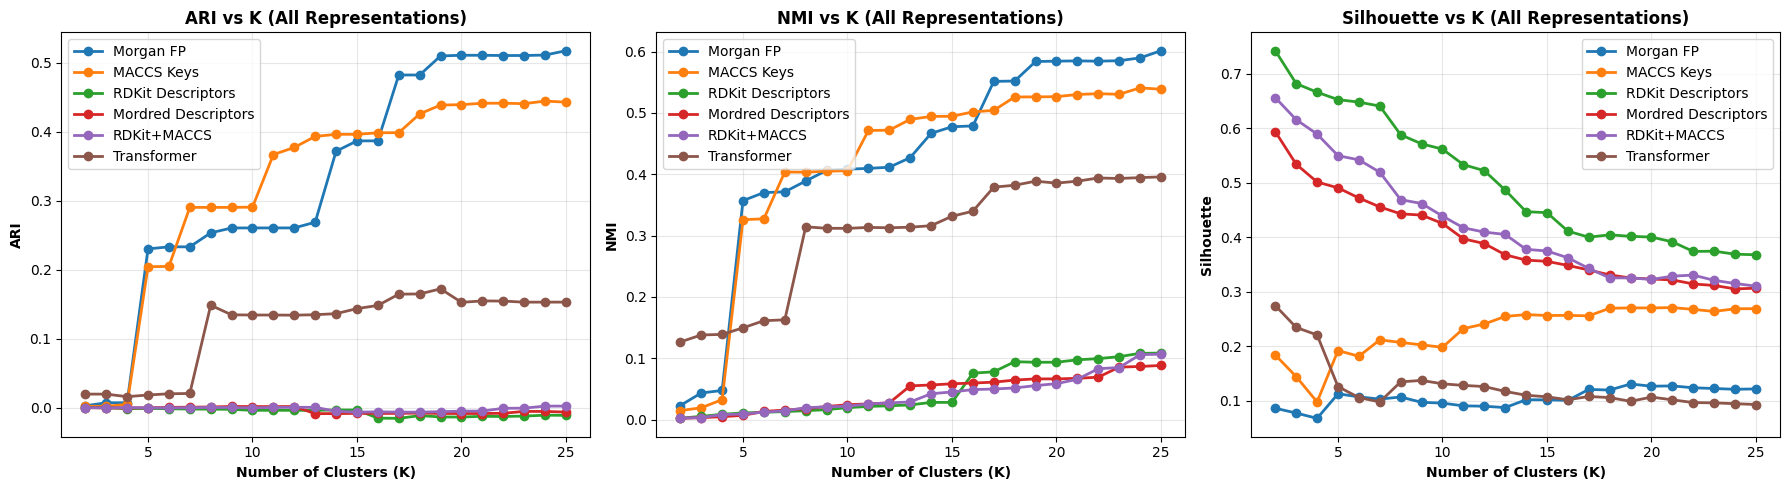

In [32]:
print("\n" + "="*80)
print("2. HIERARCHICAL CLUSTERING FOR ALL REPRESENTATIONS")
print("="*80)

all_clustering_results = {}

for repr_name, X in representations.items():
    print(f"\n{'='*60}")
    print(f"Clustering: {repr_name}")
    print(f"{'='*60}")

    # Compute distance matrix (Euclidean for continuous, Tanimoto for binary)
    if repr_name in ['Morgan FP', 'MACCS Keys']:
        # Binary - use Tanimoto/Jaccard
        print("Computing Tanimoto distance...")
        n = len(X)
        distances = []
        for i in tqdm(range(n-1), desc='Distance matrix'):
            for j in range(i+1, n):
                fp1, fp2 = X[i], X[j]
                intersection = np.sum(fp1 & fp2)
                union = np.sum(fp1 | fp2)
                sim = intersection / union if union > 0 else 0
                distances.append(1 - sim)
        dist_matrix = np.array(distances)
    else:
        # Continuous - use Euclidean
        print("Computing Euclidean distance...")
        dist_matrix = pdist(X, metric='euclidean')

    # Hierarchical clustering
    print("Performing hierarchical clustering...")
    linkage_matrix = linkage(dist_matrix, method='average')

    # Extract clusters for K=2 to 25
    cluster_assignments = {}
    metrics_list = []

    dist_matrix_square = squareform(dist_matrix)

    for k in tqdm(range(2, 26), desc='Extracting clusters'):
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        cluster_assignments[k] = clusters

        # Compute metrics
        ari = adjusted_rand_score(df['polymer_class'], clusters)
        nmi = normalized_mutual_info_score(df['polymer_class'], clusters)
        sil = silhouette_score(dist_matrix_square, clusters, metric='precomputed')

        metrics_list.append({
            'K': k,
            'representation': repr_name,
            'ARI': ari,
            'NMI': nmi,
            'Silhouette': sil
        })

    all_clustering_results[repr_name] = {
        'linkage': linkage_matrix,
        'clusters': cluster_assignments,
        'metrics': metrics_list
    }

    print(f"✓ Completed clustering for {repr_name}")

# Save all metrics
all_metrics_df = pd.DataFrame([m for r in all_clustering_results.values() for m in r['metrics']])
all_metrics_df.to_csv('plots/10_all_representations_clustering_metrics.csv', index=False)
print("\n✓ Saved: plots/10_all_representations_clustering_metrics.csv")

# Plot clustering metrics for all representations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for repr_name in representations.keys():
    repr_data = all_metrics_df[all_metrics_df['representation'] == repr_name]

    axes[0].plot(repr_data['K'], repr_data['ARI'], marker='o', label=repr_name, linewidth=2)
    axes[1].plot(repr_data['K'], repr_data['NMI'], marker='o', label=repr_name, linewidth=2)
    axes[2].plot(repr_data['K'], repr_data['Silhouette'], marker='o', label=repr_name, linewidth=2)

axes[0].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[0].set_ylabel('ARI', fontweight='bold')
axes[0].set_title('ARI vs K (All Representations)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[1].set_ylabel('NMI', fontweight='bold')
axes[1].set_title('NMI vs K (All Representations)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[2].set_ylabel('Silhouette', fontweight='bold')
axes[2].set_title('Silhouette vs K (All Representations)', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/10_all_representations_clustering.png', dpi=300, bbox_inches='tight')
print("✓ Saved: plots/10_all_representations_clustering.png")
plt.show()


3. K-MEANS CLUSTERING ON TRANSFORMER EMBEDDINGS


K-means clustering:   0%|          | 0/24 [00:00<?, ?it/s]

K=2: ARI=0.0176, NMI=0.1146, Silhouette=0.3421
K=3: ARI=0.1408, NMI=0.2569, Silhouette=0.2237
K=4: ARI=0.1176, NMI=0.2426, Silhouette=0.1394
K=5: ARI=0.1632, NMI=0.3137, Silhouette=0.1307
K=6: ARI=0.1787, NMI=0.3165, Silhouette=0.1322
K=7: ARI=0.1931, NMI=0.3670, Silhouette=0.1271
K=8: ARI=0.2357, NMI=0.4026, Silhouette=0.1075
K=9: ARI=0.2574, NMI=0.4163, Silhouette=0.1084
K=10: ARI=0.2709, NMI=0.4339, Silhouette=0.1101
K=11: ARI=0.2720, NMI=0.4266, Silhouette=0.1172
K=12: ARI=0.2641, NMI=0.4474, Silhouette=0.1150
K=13: ARI=0.2903, NMI=0.4677, Silhouette=0.1123
K=14: ARI=0.2321, NMI=0.4329, Silhouette=0.1237
K=15: ARI=0.2397, NMI=0.4491, Silhouette=0.1283
K=16: ARI=0.2418, NMI=0.4610, Silhouette=0.1158
K=17: ARI=0.2313, NMI=0.4506, Silhouette=0.1133
K=18: ARI=0.2350, NMI=0.4579, Silhouette=0.1148
K=19: ARI=0.2068, NMI=0.4479, Silhouette=0.1222
K=20: ARI=0.2259, NMI=0.4654, Silhouette=0.1271
K=21: ARI=0.2060, NMI=0.4600, Silhouette=0.1121
K=22: ARI=0.2048, NMI=0.4553, Silhouette=0.1224


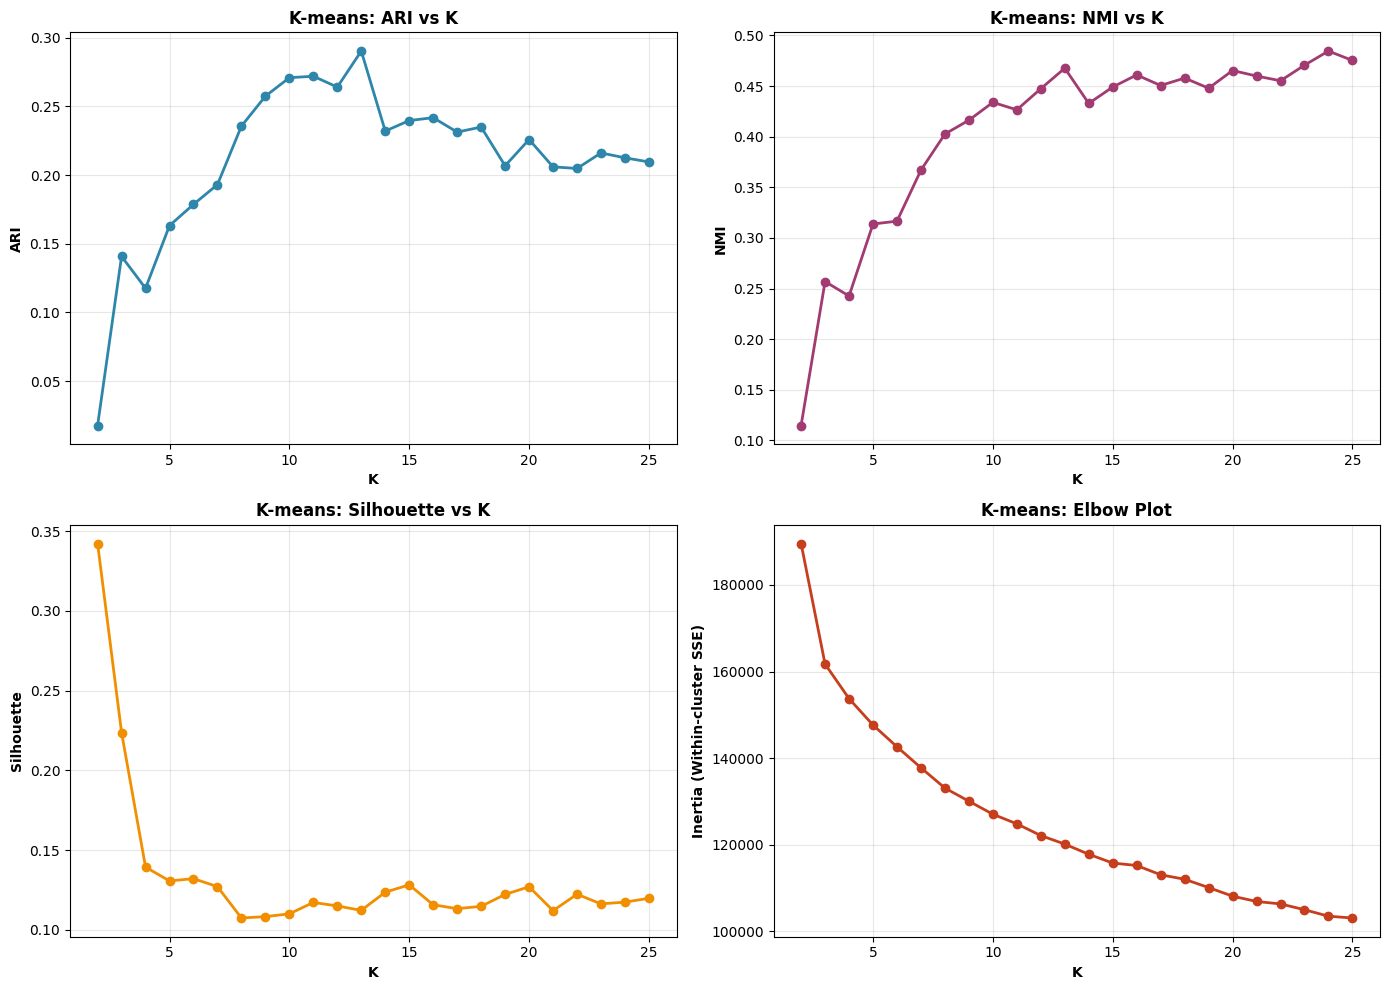

In [33]:
print("\n" + "="*80)
print("3. K-MEANS CLUSTERING ON TRANSFORMER EMBEDDINGS")
print("="*80)

kmeans_results = []

for k in tqdm(range(2, 26), desc='K-means clustering'):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_transformer)

    # Compute metrics
    ari = adjusted_rand_score(df['polymer_class'], clusters)
    nmi = normalized_mutual_info_score(df['polymer_class'], clusters)
    sil = silhouette_score(X_transformer, clusters)
    inertia = kmeans.inertia_

    kmeans_results.append({
        'K': k,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil,
        'Inertia': inertia,
        'clusters': clusters
    })

    print(f"K={k}: ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}")

# Save results
kmeans_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'clusters'} for r in kmeans_results])
kmeans_df.to_csv('plots/11_kmeans_transformer_metrics.csv', index=False)
print("\n✓ Saved: plots/11_kmeans_transformer_metrics.csv")

# Plot K-means metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(kmeans_df['K'], kmeans_df['ARI'], marker='o', color='#2E86AB', linewidth=2)
axes[0, 0].set_xlabel('K', fontweight='bold')
axes[0, 0].set_ylabel('ARI', fontweight='bold')
axes[0, 0].set_title('K-means: ARI vs K', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(kmeans_df['K'], kmeans_df['NMI'], marker='o', color='#A23B72', linewidth=2)
axes[0, 1].set_xlabel('K', fontweight='bold')
axes[0, 1].set_ylabel('NMI', fontweight='bold')
axes[0, 1].set_title('K-means: NMI vs K', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(kmeans_df['K'], kmeans_df['Silhouette'], marker='o', color='#F18F01', linewidth=2)
axes[1, 0].set_xlabel('K', fontweight='bold')
axes[1, 0].set_ylabel('Silhouette', fontweight='bold')
axes[1, 0].set_title('K-means: Silhouette vs K', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(kmeans_df['K'], kmeans_df['Inertia'], marker='o', color='#C73E1D', linewidth=2)
axes[1, 1].set_xlabel('K', fontweight='bold')
axes[1, 1].set_ylabel('Inertia (Within-cluster SSE)', fontweight='bold')
axes[1, 1].set_title('K-means: Elbow Plot', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/11_kmeans_transformer.png', dpi=300, bbox_inches='tight')
print("✓ Saved: plots/11_kmeans_transformer.png")
plt.show()



4. SUPERVISED LEARNING USING CLUSTER IDS AS FEATURES

Training with K=5 cluster features
Feature matrix shape: (1077, 7)
Features: ['Morgan FP_cluster', 'MACCS Keys_cluster', 'RDKit Descriptors_cluster', 'Mordred Descriptors_cluster', 'RDKit+MACCS_cluster', 'Transformer_cluster', 'Transformer_KMeans_cluster']
Test Acc: 0.4327 ± 0.0212
Test F1:  0.1113 ± 0.0128

Training with K=10 cluster features
Feature matrix shape: (1077, 7)
Features: ['Morgan FP_cluster', 'MACCS Keys_cluster', 'RDKit Descriptors_cluster', 'Mordred Descriptors_cluster', 'RDKit+MACCS_cluster', 'Transformer_cluster', 'Transformer_KMeans_cluster']
Test Acc: 0.5421 ± 0.0290
Test F1:  0.2854 ± 0.0252

Training with K=15 cluster features
Feature matrix shape: (1077, 7)
Features: ['Morgan FP_cluster', 'MACCS Keys_cluster', 'RDKit Descriptors_cluster', 'Mordred Descriptors_cluster', 'RDKit+MACCS_cluster', 'Transformer_cluster', 'Transformer_KMeans_cluster']
Test Acc: 0.5262 ± 0.0161
Test F1:  0.2791 ± 0.0165

Training with

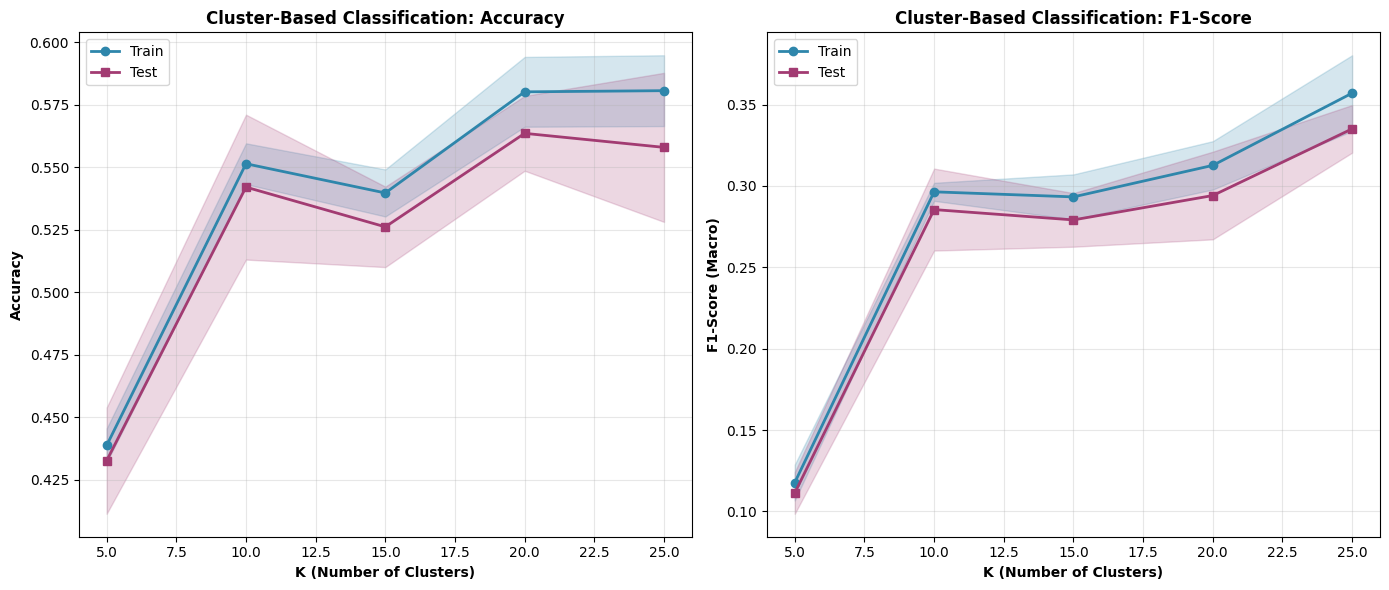


ALL ADDITIONAL ANALYSES COMPLETE!

Generated files:
  - plots/09_stratified_5fold_cv_results.csv
  - plots/09_stratified_5fold_cv.png
  - plots/10_all_representations_clustering_metrics.csv
  - plots/10_all_representations_clustering.png
  - plots/11_kmeans_transformer_metrics.csv
  - plots/11_kmeans_transformer.png
  - plots/12_cluster_based_prediction.csv
  - plots/12_cluster_based_prediction.png


In [34]:
print("\n" + "="*80)
print("4. SUPERVISED LEARNING USING CLUSTER IDS AS FEATURES")
print("="*80)

# Create feature matrices with cluster assignments
cluster_feature_results = []

for k in [5, 10, 15, 20, 25]:
    print(f"\n{'='*60}")
    print(f"Training with K={k} cluster features")
    print(f"{'='*60}")

    # Collect cluster assignments from all representations
    cluster_features = []
    feature_names = []

    # Hierarchical clustering for each representation
    for repr_name in representations.keys():
        if repr_name in all_clustering_results:
            clusters = all_clustering_results[repr_name]['clusters'][k]
            cluster_features.append(clusters.reshape(-1, 1))
            feature_names.append(f'{repr_name}_cluster')

    # K-means clusters from transformer
    kmeans_clusters = [r['clusters'] for r in kmeans_results if r['K'] == k][0]
    cluster_features.append(kmeans_clusters.reshape(-1, 1))
    feature_names.append('Transformer_KMeans_cluster')

    # Combine all cluster features
    X_clusters = np.hstack(cluster_features)

    print(f"Feature matrix shape: {X_clusters.shape}")
    print(f"Features: {feature_names}")

    # 5-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_clusters[mask], y_filtered), 1):
        X_train = X_clusters[mask][train_idx]
        X_test = X_clusters[mask][test_idx]
        y_train = y_filtered[train_idx]
        y_test = y_filtered[test_idx]

        model = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1)  # L2 regularization
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        fold_results.append({
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_f1': train_f1,
            'test_f1': test_f1
        })

    cluster_feature_results.append({
        'K': k,
        'train_acc_mean': np.mean([r['train_acc'] for r in fold_results]),
        'train_acc_std': np.std([r['train_acc'] for r in fold_results]),
        'test_acc_mean': np.mean([r['test_acc'] for r in fold_results]),
        'test_acc_std': np.std([r['test_acc'] for r in fold_results]),
        'train_f1_mean': np.mean([r['train_f1'] for r in fold_results]),
        'train_f1_std': np.std([r['train_f1'] for r in fold_results]),
        'test_f1_mean': np.mean([r['test_f1'] for r in fold_results]),
        'test_f1_std': np.std([r['test_f1'] for r in fold_results])
    })

    print(f"Test Acc: {cluster_feature_results[-1]['test_acc_mean']:.4f} ± {cluster_feature_results[-1]['test_acc_std']:.4f}")
    print(f"Test F1:  {cluster_feature_results[-1]['test_f1_mean']:.4f} ± {cluster_feature_results[-1]['test_f1_std']:.4f}")

# Save results
cluster_pred_df = pd.DataFrame(cluster_feature_results)
cluster_pred_df.to_csv('plots/12_cluster_based_prediction.csv', index=False)
print("\n✓ Saved: plots/12_cluster_based_prediction.csv")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(cluster_pred_df['K'], cluster_pred_df['train_acc_mean'],
             marker='o', label='Train', linewidth=2, color='#2E86AB')
axes[0].fill_between(cluster_pred_df['K'],
                      cluster_pred_df['train_acc_mean'] - cluster_pred_df['train_acc_std'],
                      cluster_pred_df['train_acc_mean'] + cluster_pred_df['train_acc_std'],
                      alpha=0.2, color='#2E86AB')
axes[0].plot(cluster_pred_df['K'], cluster_pred_df['test_acc_mean'],
             marker='s', label='Test', linewidth=2, color='#A23B72')
axes[0].fill_between(cluster_pred_df['K'],
                      cluster_pred_df['test_acc_mean'] - cluster_pred_df['test_acc_std'],
                      cluster_pred_df['test_acc_mean'] + cluster_pred_df['test_acc_std'],
                      alpha=0.2, color='#A23B72')
axes[0].set_xlabel('K (Number of Clusters)', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Cluster-Based Classification: Accuracy', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(cluster_pred_df['K'], cluster_pred_df['train_f1_mean'],
             marker='o', label='Train', linewidth=2, color='#2E86AB')
axes[1].fill_between(cluster_pred_df['K'],
                      cluster_pred_df['train_f1_mean'] - cluster_pred_df['train_f1_std'],
                      cluster_pred_df['train_f1_mean'] + cluster_pred_df['train_f1_std'],
                      alpha=0.2, color='#2E86AB')
axes[1].plot(cluster_pred_df['K'], cluster_pred_df['test_f1_mean'],
             marker='s', label='Test', linewidth=2, color='#A23B72')
axes[1].fill_between(cluster_pred_df['K'],
                      cluster_pred_df['test_f1_mean'] - cluster_pred_df['test_f1_std'],
                      cluster_pred_df['test_f1_mean'] + cluster_pred_df['test_f1_std'],
                      alpha=0.2, color='#A23B72')
axes[1].set_xlabel('K (Number of Clusters)', fontweight='bold')
axes[1].set_ylabel('F1-Score (Macro)', fontweight='bold')
axes[1].set_title('Cluster-Based Classification: F1-Score', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/12_cluster_based_prediction.png', dpi=300, bbox_inches='tight')
print("✓ Saved: plots/12_cluster_based_prediction.png")
plt.show()

print("\n" + "="*80)
print("ALL ADDITIONAL ANALYSES COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  - plots/09_stratified_5fold_cv_results.csv")
print("  - plots/09_stratified_5fold_cv.png")
print("  - plots/10_all_representations_clustering_metrics.csv")
print("  - plots/10_all_representations_clustering.png")
print("  - plots/11_kmeans_transformer_metrics.csv")
print("  - plots/11_kmeans_transformer.png")
print("  - plots/12_cluster_based_prediction.csv")
print("  - plots/12_cluster_based_prediction.png")
